In [83]:
# This notebook shows an example of how to decode the data in the EvAAL API format to pandas DataFrame.
# Please note that the format of the txt file in ../trials/ is what returned through EvAAL API in the competition.
# In the real competition in September, you need to get data throught EvAAL API.
import importlib

from sub import estimate

importlib.reload(estimate)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (20, 12)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [84]:
# LOG_FILE_PATH = "../trials/Track5_second_evaluation_01_pdr.txt"
LOG_FILE_PATH = "../trials/4_1_51_pdr.txt"
GIS_BASE_PATH = "../gis/"
BEACON_LIST_PATH = GIS_BASE_PATH + "beacon_list.csv"
FLOOR_NAMES = ["FLU01", "FLU02", "FLD01"]

In [85]:
from collections import defaultdict

# Prepare containers for the data
data = defaultdict(list)

with open(LOG_FILE_PATH) as f:
    for line in f:
        line_contents = line.rstrip("\n").split(";")
        DATA_TYPE = line_contents[0]

        if DATA_TYPE == "BLUE":
            data["BLUE"].append(
                {
                    "ts": float(line_contents[1]),
                    "bdaddress": line_contents[2],
                    "rssi": int(line_contents[4]),
                },
            )

        elif DATA_TYPE in ["ACCE", "GYRO", "MAGN"]:
            record = {
                "ts": float(line_contents[1]),
                "accuracy": int(line_contents[6]),
                "x": float(line_contents[3]),
                "y": float(line_contents[4]),
                "z": float(line_contents[5]),
            }
            data[DATA_TYPE].append(record)

        elif DATA_TYPE == "POS3":
            data["POS3"].append(
                {
                    "%time": float(line_contents[1]),
                    "x": float(line_contents[3]),
                    "y": float(line_contents[4]),
                    "z": float(line_contents[5]),
                    "q0": float(line_contents[6]),
                    "q1": float(line_contents[7]),
                    "q2": float(line_contents[8]),
                    "q3": float(line_contents[9]),
                    "floor": line_contents[10],
                },
            )

# Convert lists of dictionaries to dataframes
blescans = pd.DataFrame(data["BLUE"])
acc = pd.DataFrame(data["ACCE"])
print(acc)
gyro = pd.DataFrame(data["GYRO"])
mgf = pd.DataFrame(data["MAGN"])
gt_ref = pd.DataFrame(data["POS3"])
# acc.reset_index(inplace=True, drop=True)
# gyro.reset_index(inplace=True, drop=True)
# mgf.reset_index(inplace=True, drop=True)
# gt_ref.reset_index(inplace=True, drop=True)

# csvで保存
acc.to_csv("acc.csv", index=False)
gyro.to_csv("gyro.csv", index=False)
mgf.to_csv("mgf.csv", index=False)
gt_ref.to_csv("gt_ref.csv", index=False)

               ts  accuracy          x         y         z
0        0.003125         3   9.433155 -0.861913  2.097321
1        0.013075         3   9.452309 -0.871489  2.183512
2        0.023024         3   9.442732 -0.881066  2.202666
3        0.032974         3   9.433155 -0.871489  2.240973
4        0.042923         3   9.500193 -0.852336  2.240973
5        0.052873         3   9.528923 -0.756568  2.231396
6        0.062822         3   9.500193 -0.689530  2.202666
7        0.072772         3   9.490616 -0.670376  2.327164
8        0.082721         3   9.414001 -0.641646  2.336741
9        0.092671         3   9.423578 -0.689530  2.413355
10       0.102620         3   9.366117 -0.775721  2.442086
11       0.112570         3   9.337387 -0.842759  2.461239
12       0.122519         3   9.375694 -0.967257  2.509123
13       0.132469         3   9.433155 -1.024718  2.470816
14       0.142418         3   9.375694 -1.034295  2.576161
15       0.152368         3   9.385271 -1.063026  2.5378

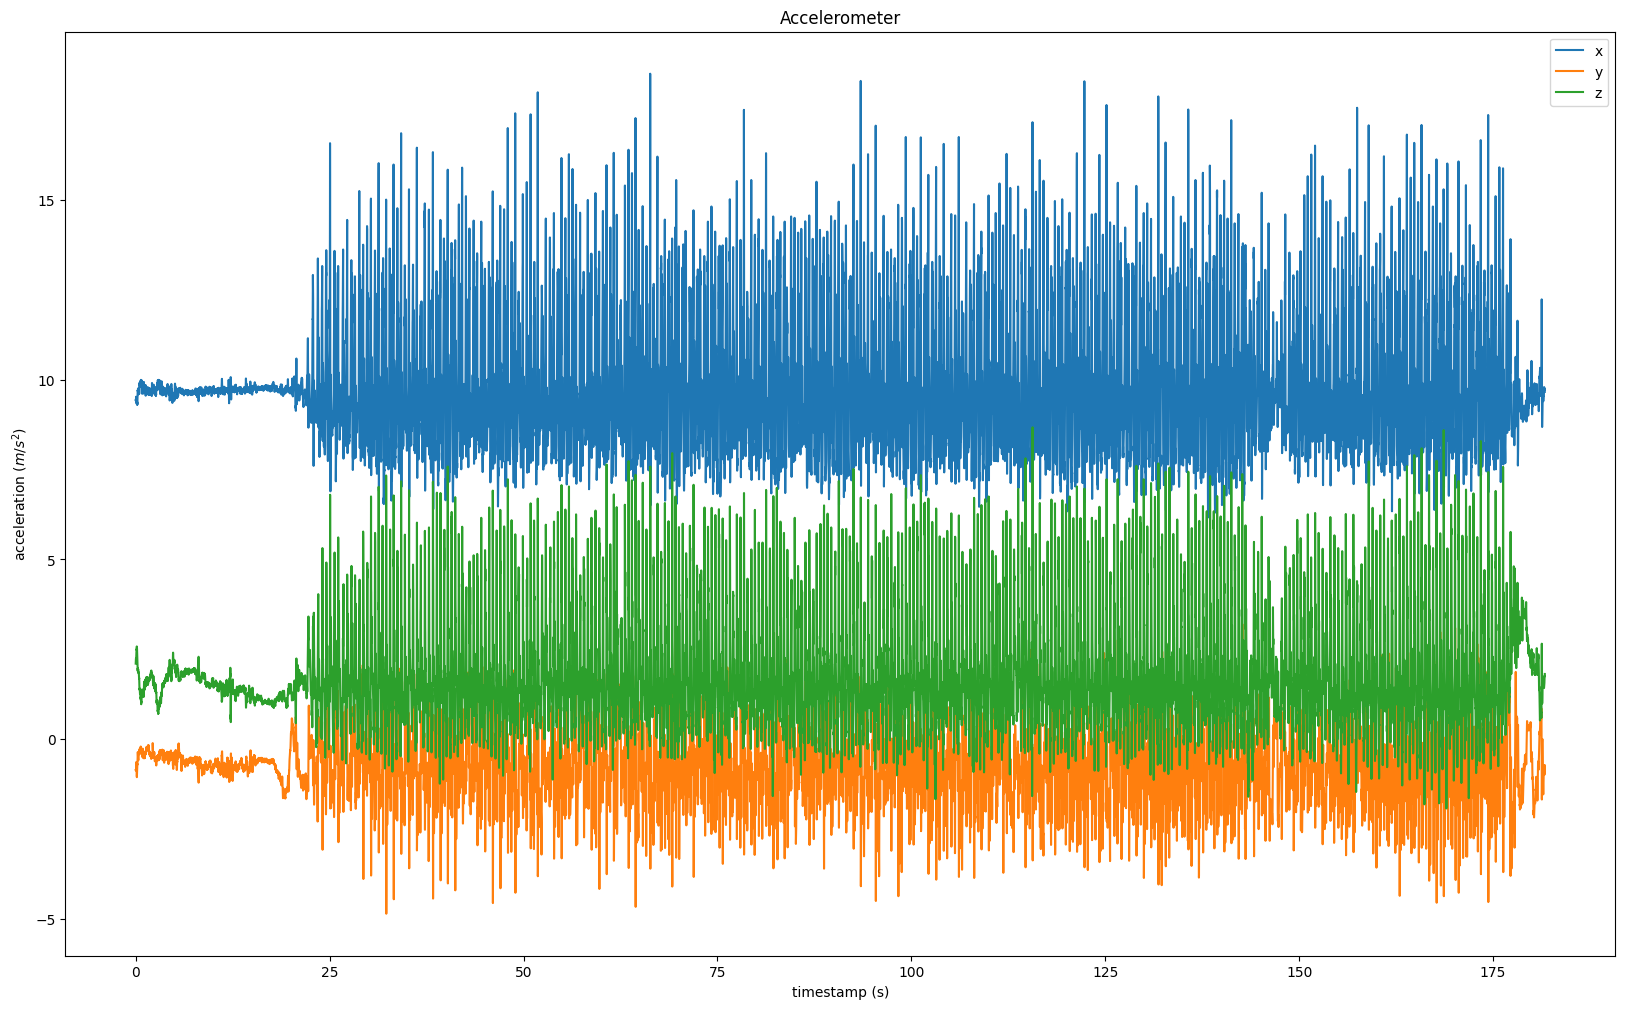

In [86]:
plt.plot(acc.ts, acc[["x", "y", "z"]], label=["x", "y", "z"])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer")
plt.legend()
plt.show()

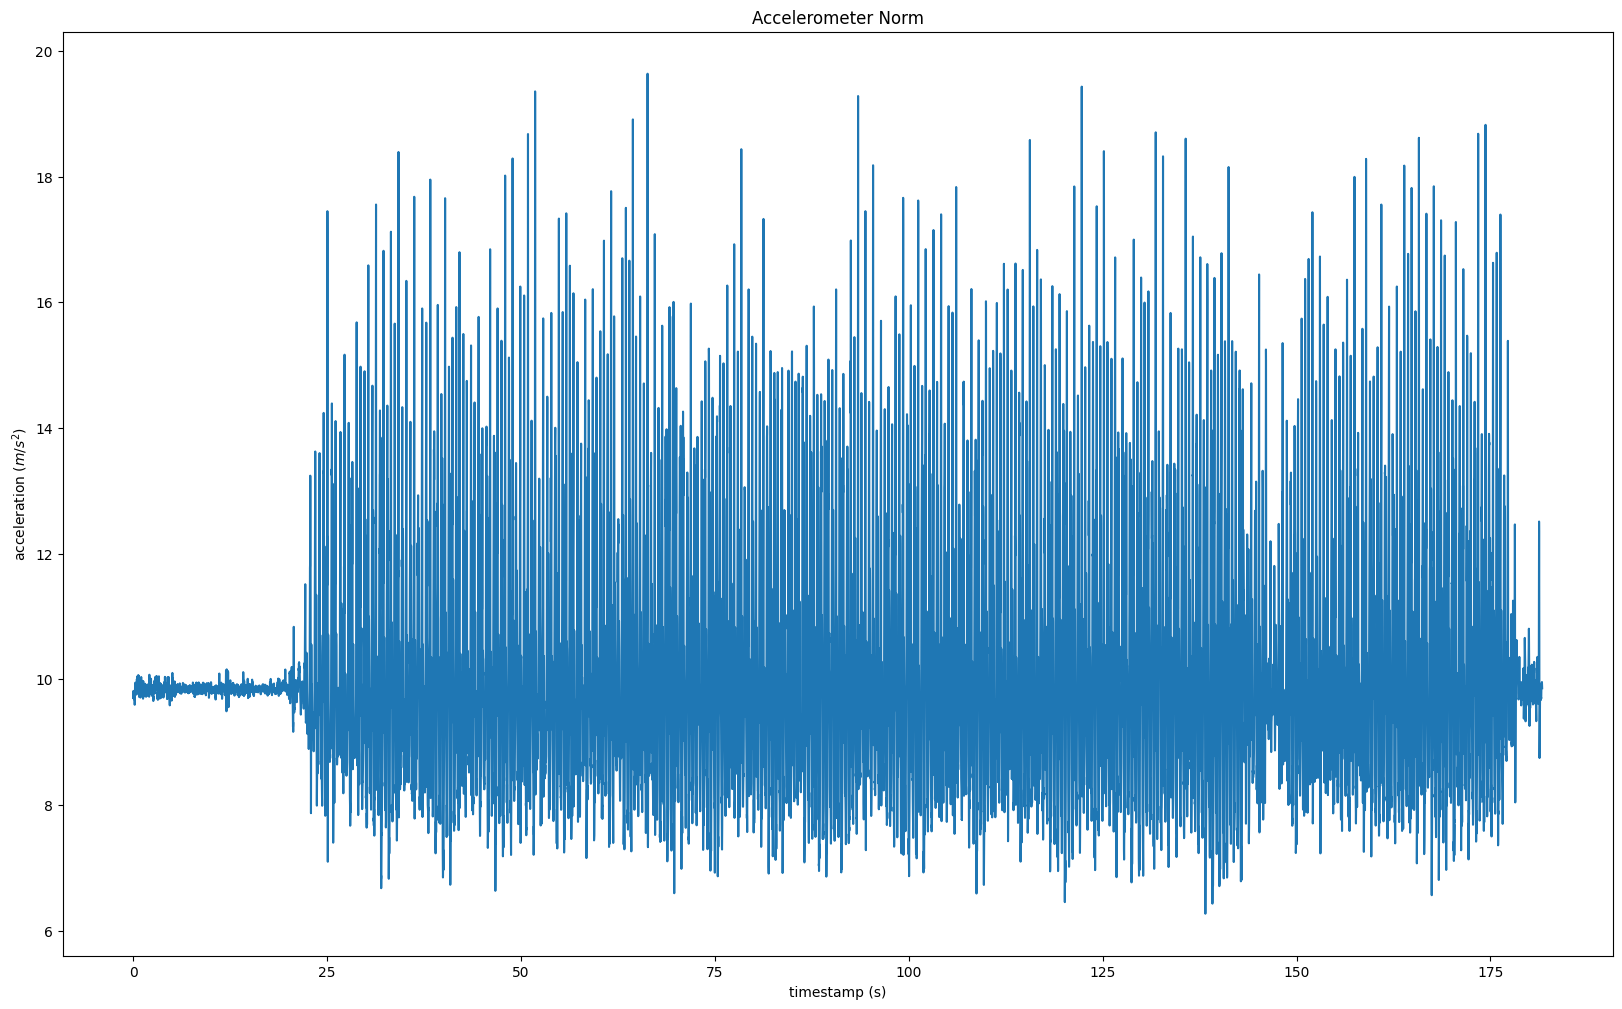

In [87]:
acc["norm"] = np.sqrt(acc["x"] ** 2 + acc["y"] ** 2 + acc["z"] ** 2)

acc.reset_index()

plt.plot(acc.ts, acc["norm"])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

Text(0.5, 1.0, 'Accelerometer Norm')

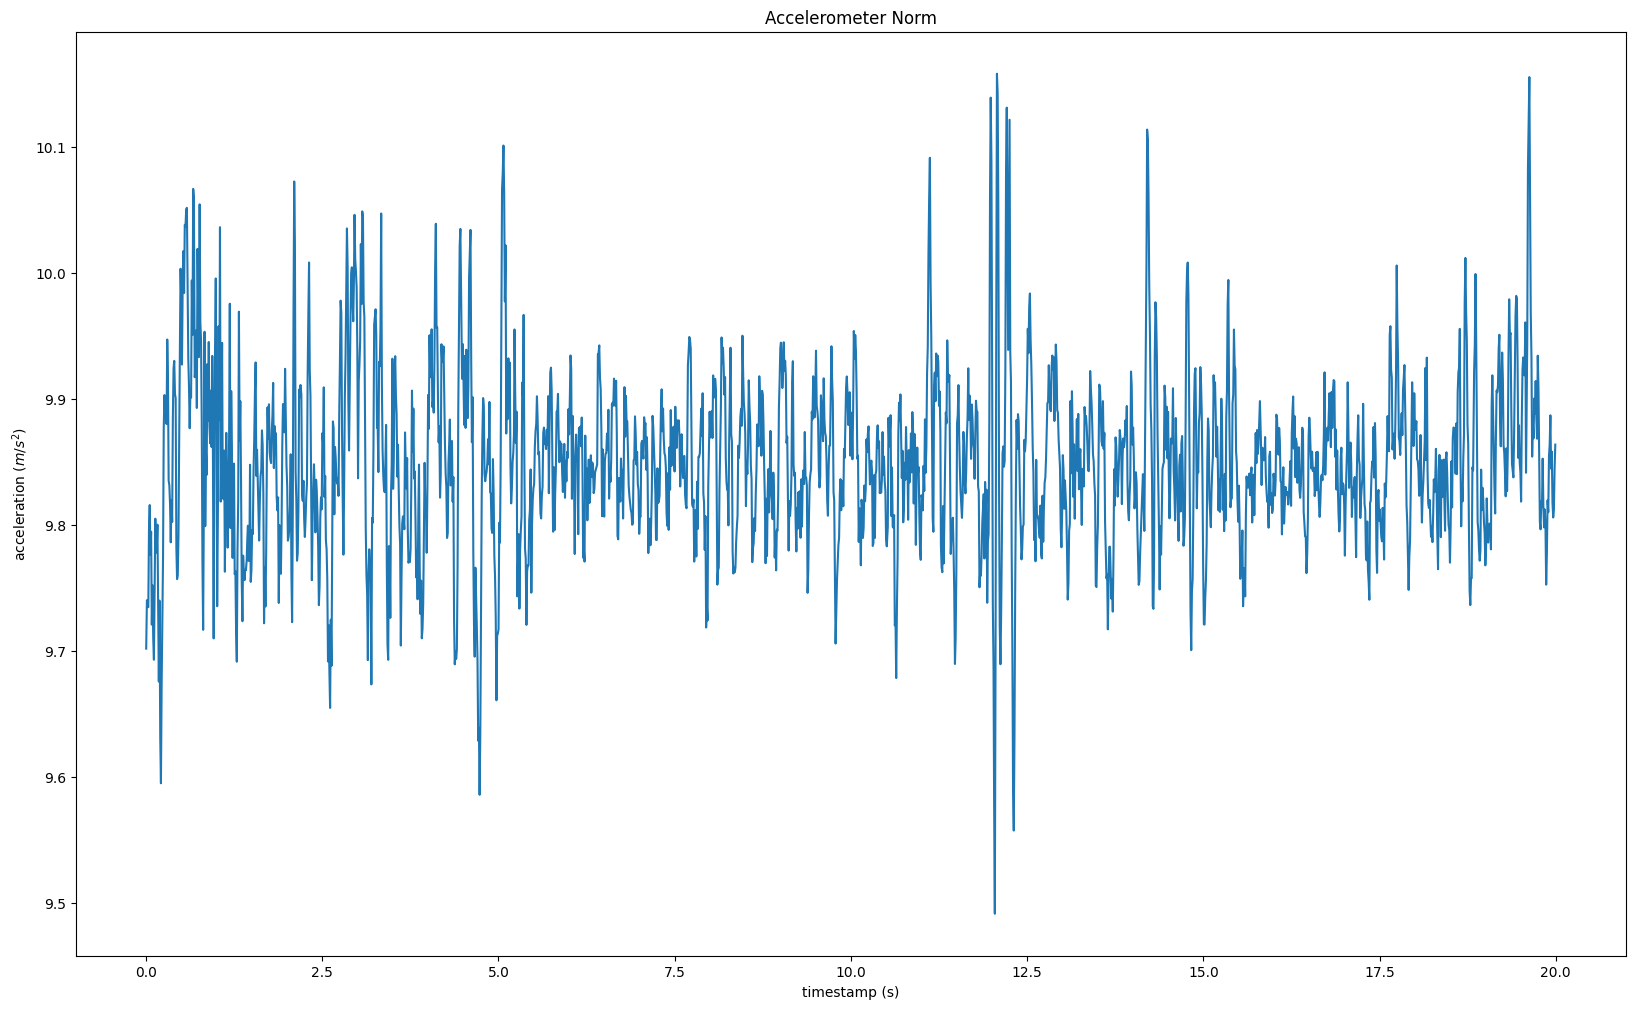

In [88]:
acc["norm"] = np.sqrt(acc["x"] ** 2 + acc["y"] ** 2 + acc["z"] ** 2)

# 時間が25秒以上50秒未満のデータを抽出
time_filter_acc = acc[(acc.ts >= 0) & (acc.ts < 20)]
time_filter_acc.reset_index(inplace=True, drop=True)

plt.plot(time_filter_acc.ts, time_filter_acc["norm"])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
# plt.show()

/var/folders/9p/p2bfdpzj5v5fs4xvn07kwlww0000gn/T/ipykernel_55425/3312375496.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_filter_acc.loc[:, "rolling_norm"] = time_filter_acc["norm"].rolling(10).mean()


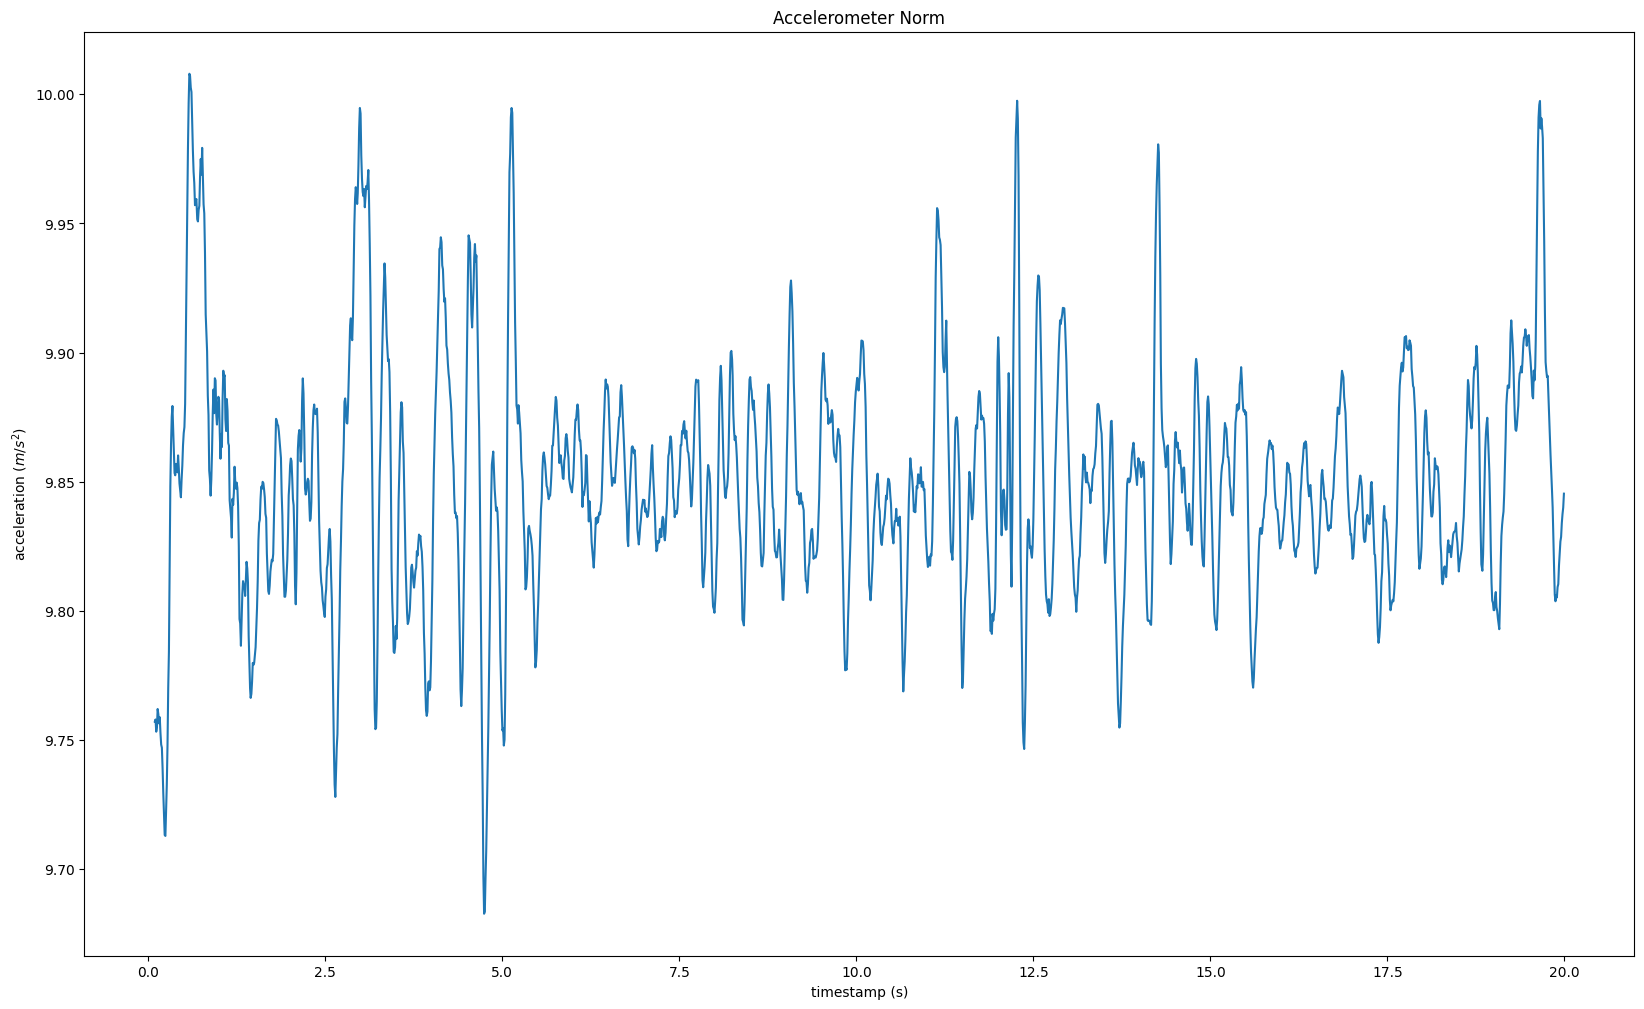

In [89]:
# 移動平均フィルターをかける
time_filter_acc.loc[:, "rolling_norm"] = time_filter_acc["norm"].rolling(10).mean()

plt.plot(time_filter_acc.ts, time_filter_acc["rolling_norm"])
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

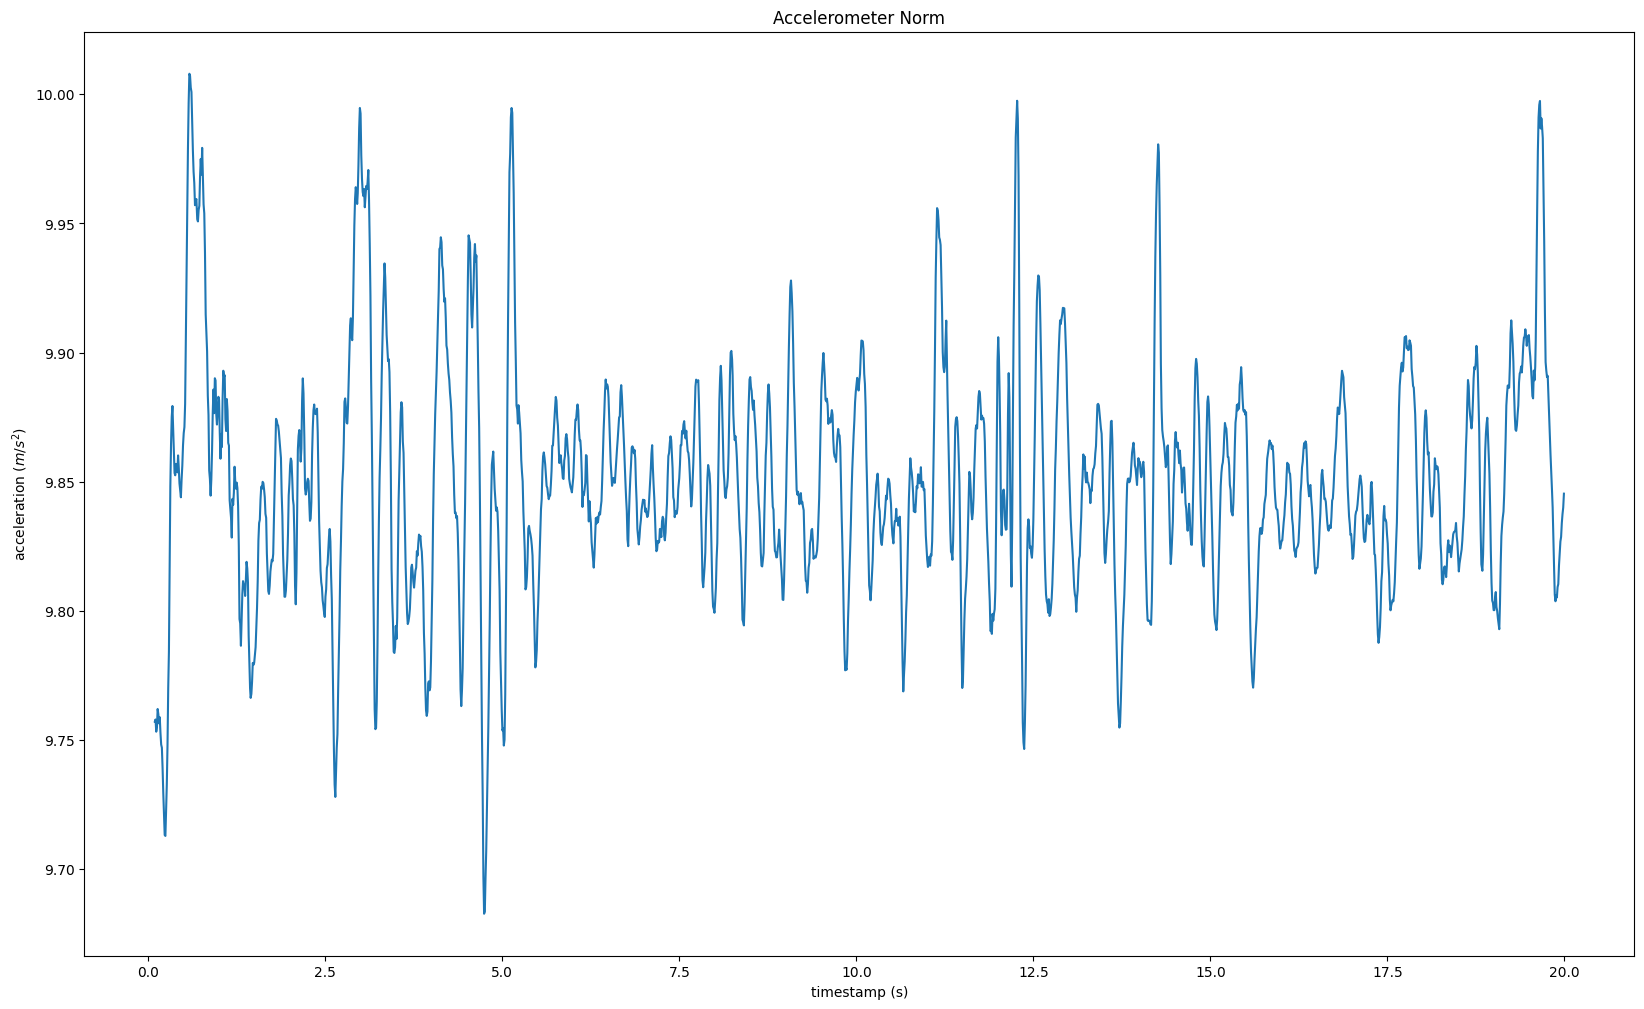

In [90]:
# ピーク検出
from scipy.signal import find_peaks

peaks, _ = find_peaks(time_filter_acc["rolling_norm"], height=12, distance=20)
plt.plot(time_filter_acc.ts, time_filter_acc["rolling_norm"])
plt.plot(time_filter_acc.ts[peaks], time_filter_acc["rolling_norm"][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

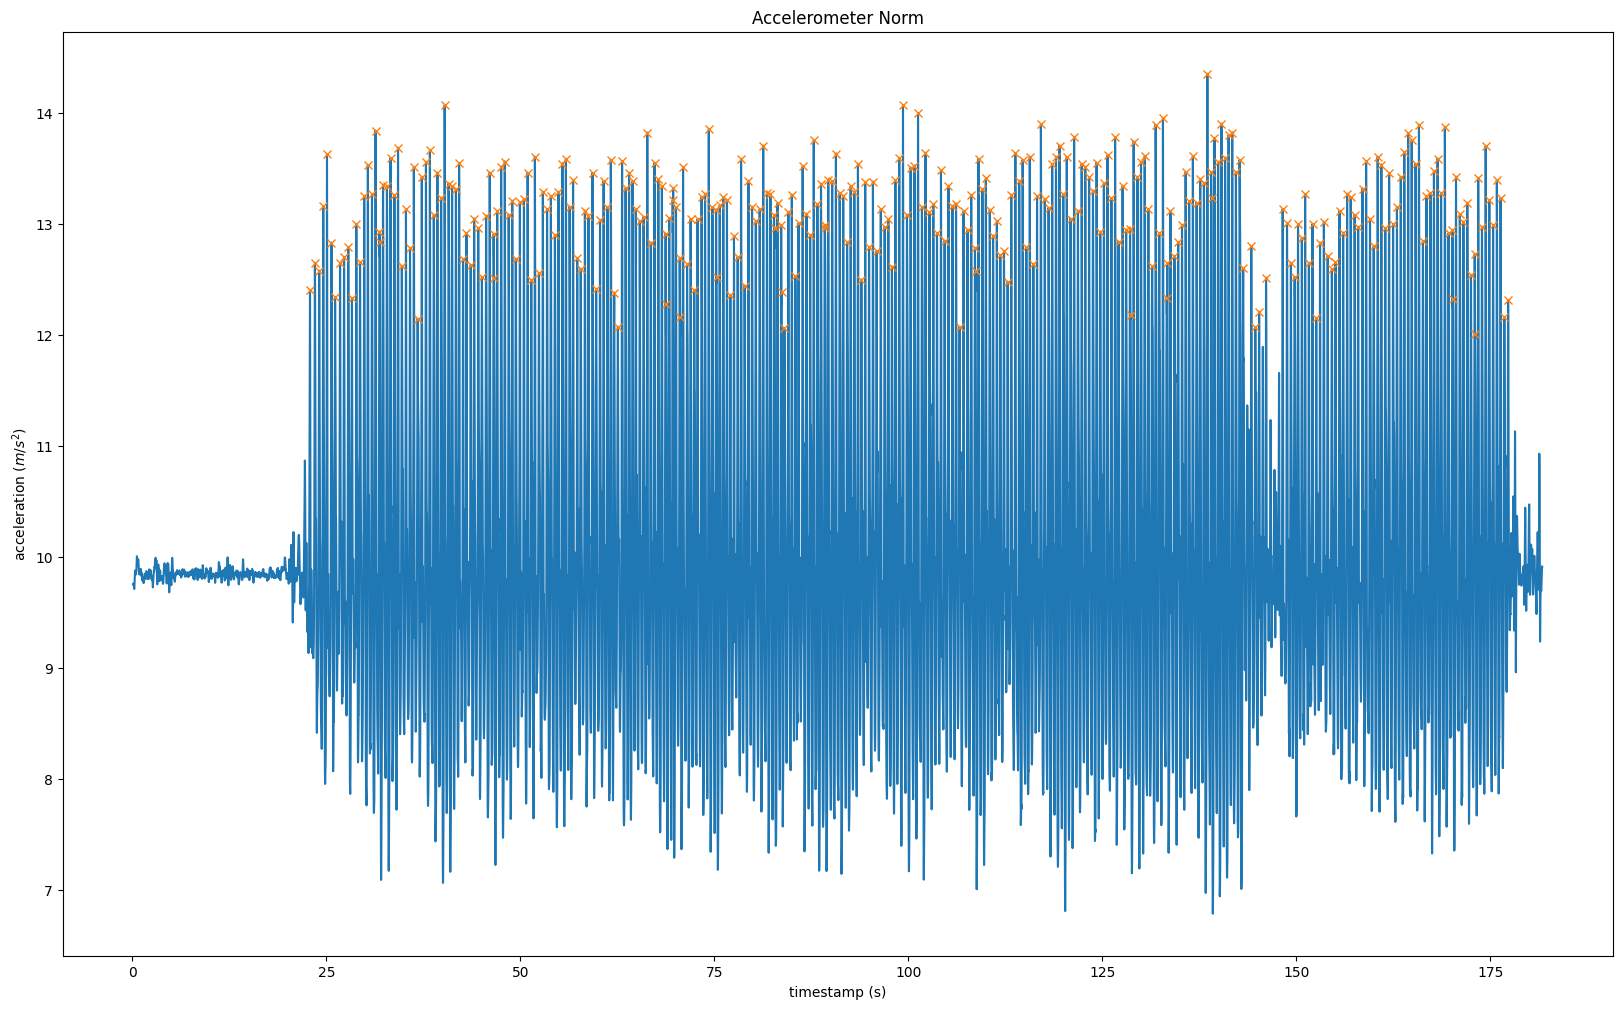

In [91]:
acc["rolling_norm"] = acc["norm"].rolling(10).mean()

peaks, _ = find_peaks(acc["rolling_norm"], height=12)

plt.plot(acc.ts, acc["rolling_norm"])
plt.plot(acc.ts[peaks], acc["rolling_norm"][peaks], "x")
plt.xlabel("timestamp (s)")
plt.ylabel("acceleration ($m/s^2$)")
plt.title("Accelerometer Norm")
plt.show()

# time_filter_acc.loc[:, 'rolling_norm'] = time_filter_acc['norm'].rolling(
#     10).mean()

# peaks, _ = find_peaks(time_filter_acc['rolling_norm'], height=11, distance=20)

# plt.plot(time_filter_acc.ts, time_filter_acc['rolling_norm'])
# plt.plot(time_filter_acc.ts[peaks],
#          time_filter_acc['rolling_norm'][peaks], "x")
# plt.xlabel("timestamp (s)")
# plt.ylabel("acceleration ($m/s^2$)")
# plt.title("Accelerometer Norm")
# plt.show()

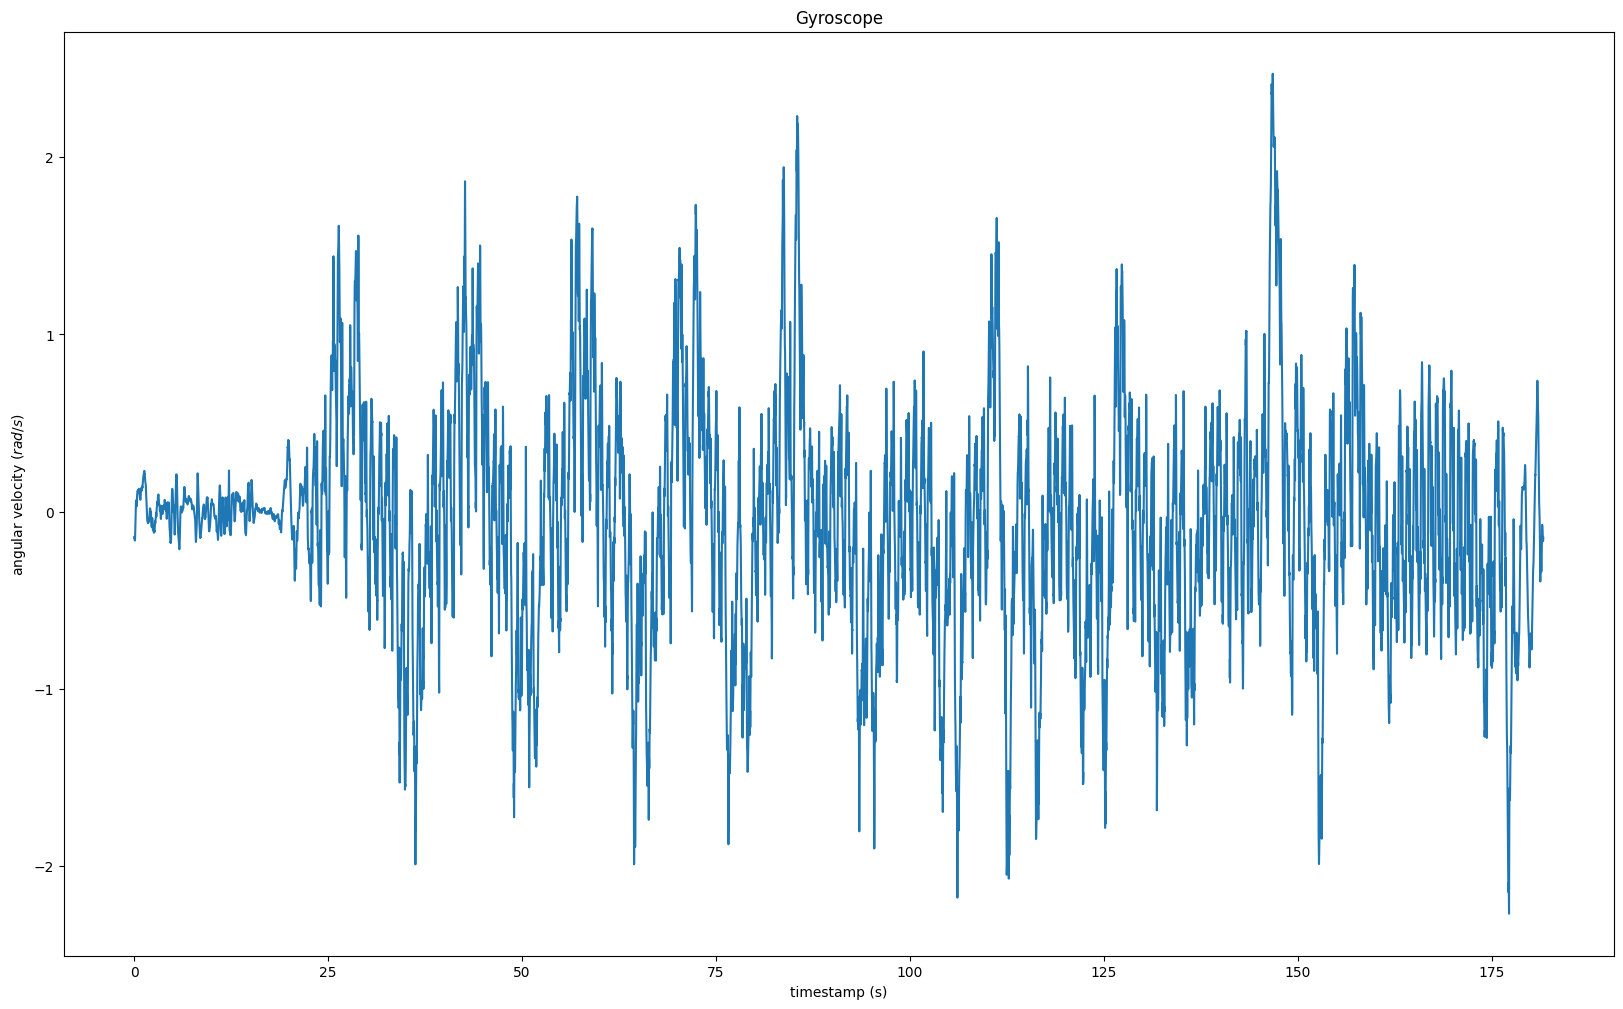

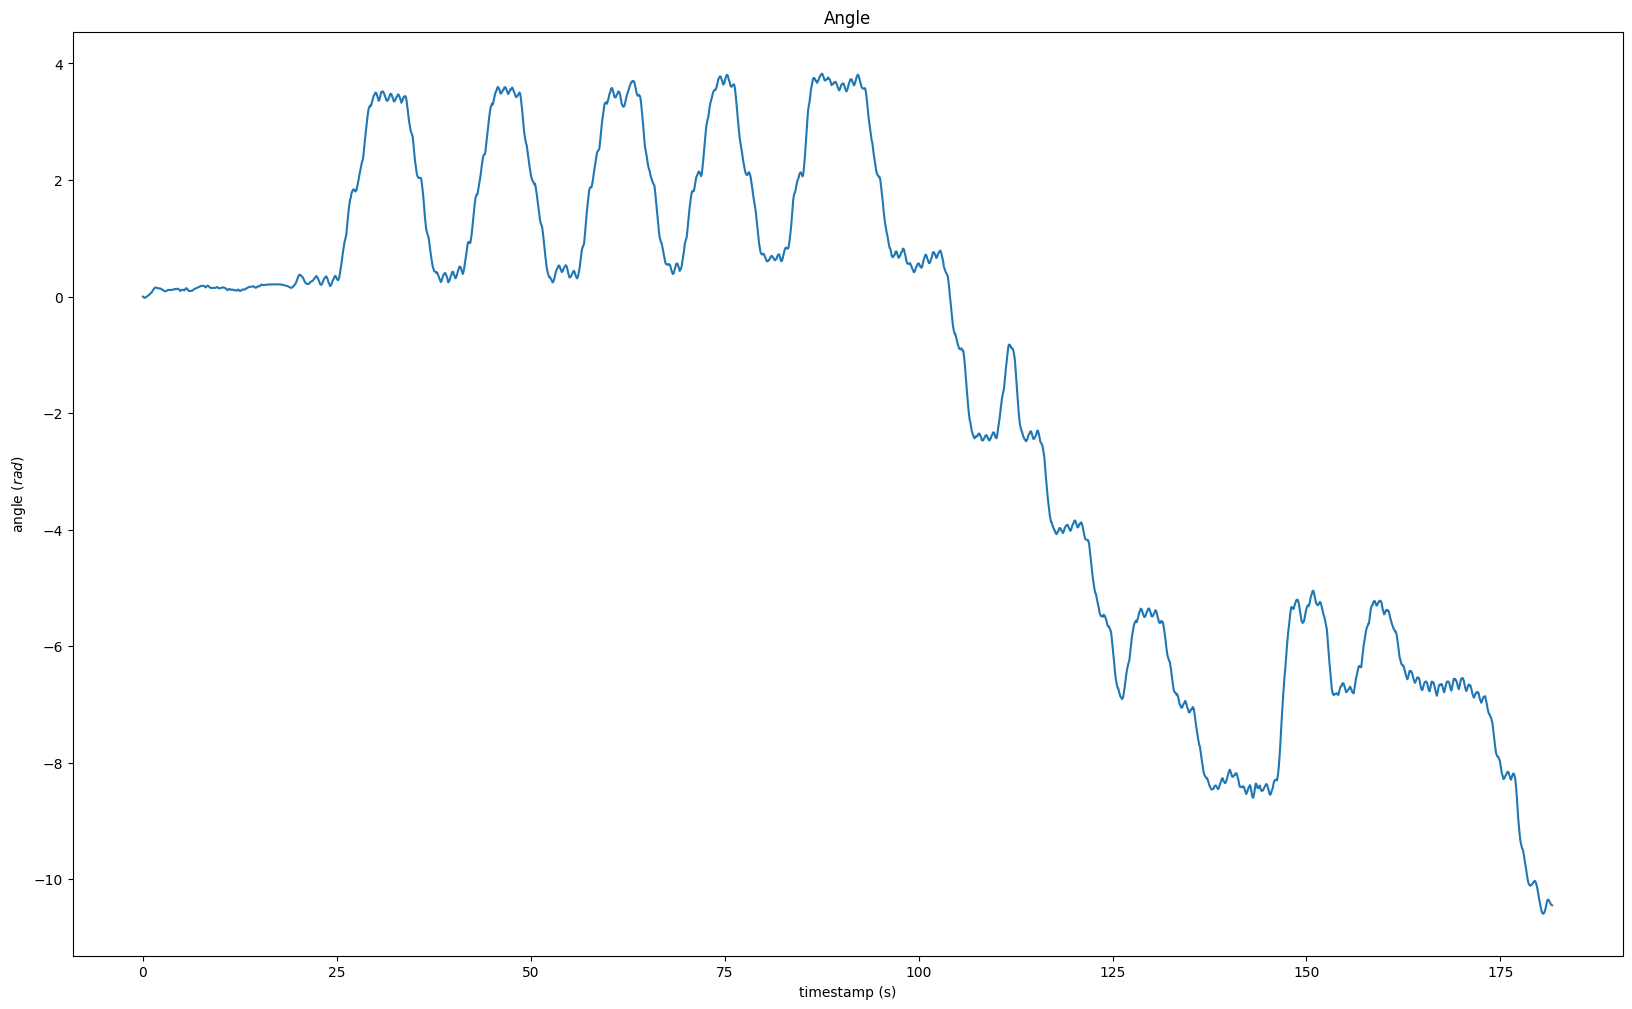

In [92]:
# def convert_to_gyro_rate(angle_df: pd.DataFrame) -> pd.DataFrame:
#     gyro_rate = pd.DataFrame()
#     gyro_rate['ts'] = angle_df['ts']
#     # 1つ前の角度との差分を取得して、微分を近似
#     # 注意：この方法はノイズが強調される可能性がある
#     gyro_rate['x'] = angle_df['x'].diff() / 0.01
#     gyro_rate = gyro_rate.dropna()  # 最初のデータポイントでのNaNを削除
#     return gyro_rate

# plt.plot(gyro.ts, gyro['x'])
# plt.xlabel("timestamp (s)")
# plt.ylabel("angular velocity ($rad/s$)")
# plt.title("Gyroscope")
# plt.show()

# # gyroデータを20秒以内に絞り込む
# time_filter_gyro = gyro[(gyro.ts >= 0) & (gyro.ts < 20)]
# time_filter_gyro.reset_index(inplace=True, drop=True)

# # plot
# plt.plot(time_filter_gyro.ts, time_filter_gyro['x'])
# plt.xlabel("timestamp (s)")
# plt.ylabel("angular velocity ($rad/s$)")
# plt.title("Gyroscope")
# plt.show()

# ジャイロ
plt.plot(gyro.ts, gyro["x"])
plt.xlabel("timestamp (s)")
plt.ylabel("angular velocity ($rad/s$)")
plt.title("Gyroscope")
plt.show()


# 角速度を積分して角度に変換
angle_df = estimate.convert_to_angle_from_gyro(gyro)

# 角度のデータをplot
plt.plot(angle_df.ts, angle_df["x"])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()

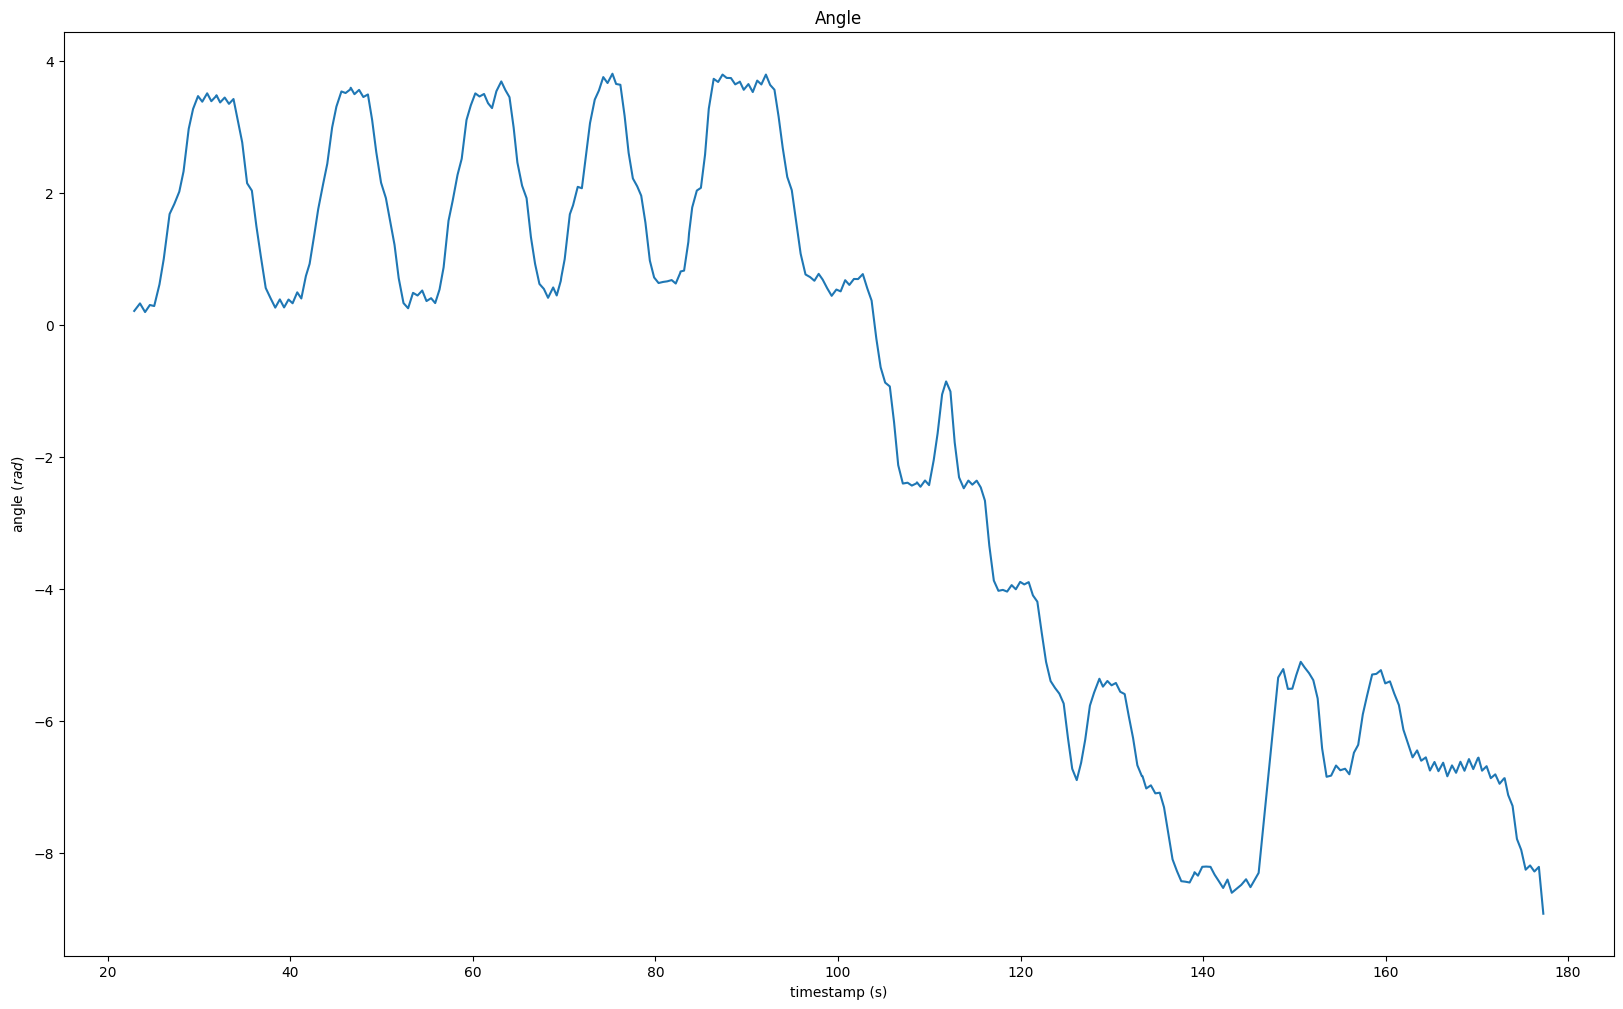

In [93]:
# ジャイロを積分して角度に変換
angle_in_step_timing = pd.DataFrame()
angle_in_step_timing = estimate.convert_to_peek_angle(gyro, acc, peaks)

plt.plot(angle_in_step_timing.ts, angle_in_step_timing["x"])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()

In [94]:
dx = 0.01
dy = 0.01

# read bitmap image of the floor movable areas
map_dict = {}
for floor_name in FLOOR_NAMES:
    map_dict[floor_name] = estimate.load_bitmap(
        GIS_BASE_PATH + floor_name + "_0.01_0.01.bmp",
    )

edit_map_dict = {}
for floor_name in FLOOR_NAMES:
    edit_map_dict[floor_name] = estimate.load_bitmap(
        GIS_BASE_PATH + floor_name + "_0.01_0.01_edited.bmp",
    )

floor_name = gt_ref.floor[0]

print(map_dict[floor_name].shape)

(5451, 2931)


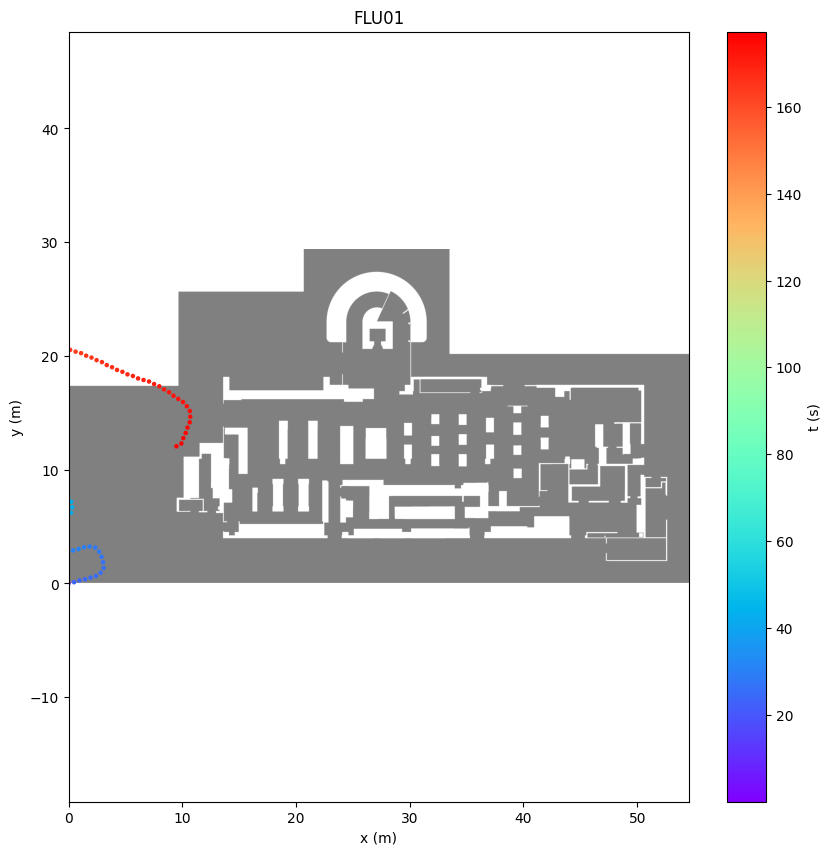

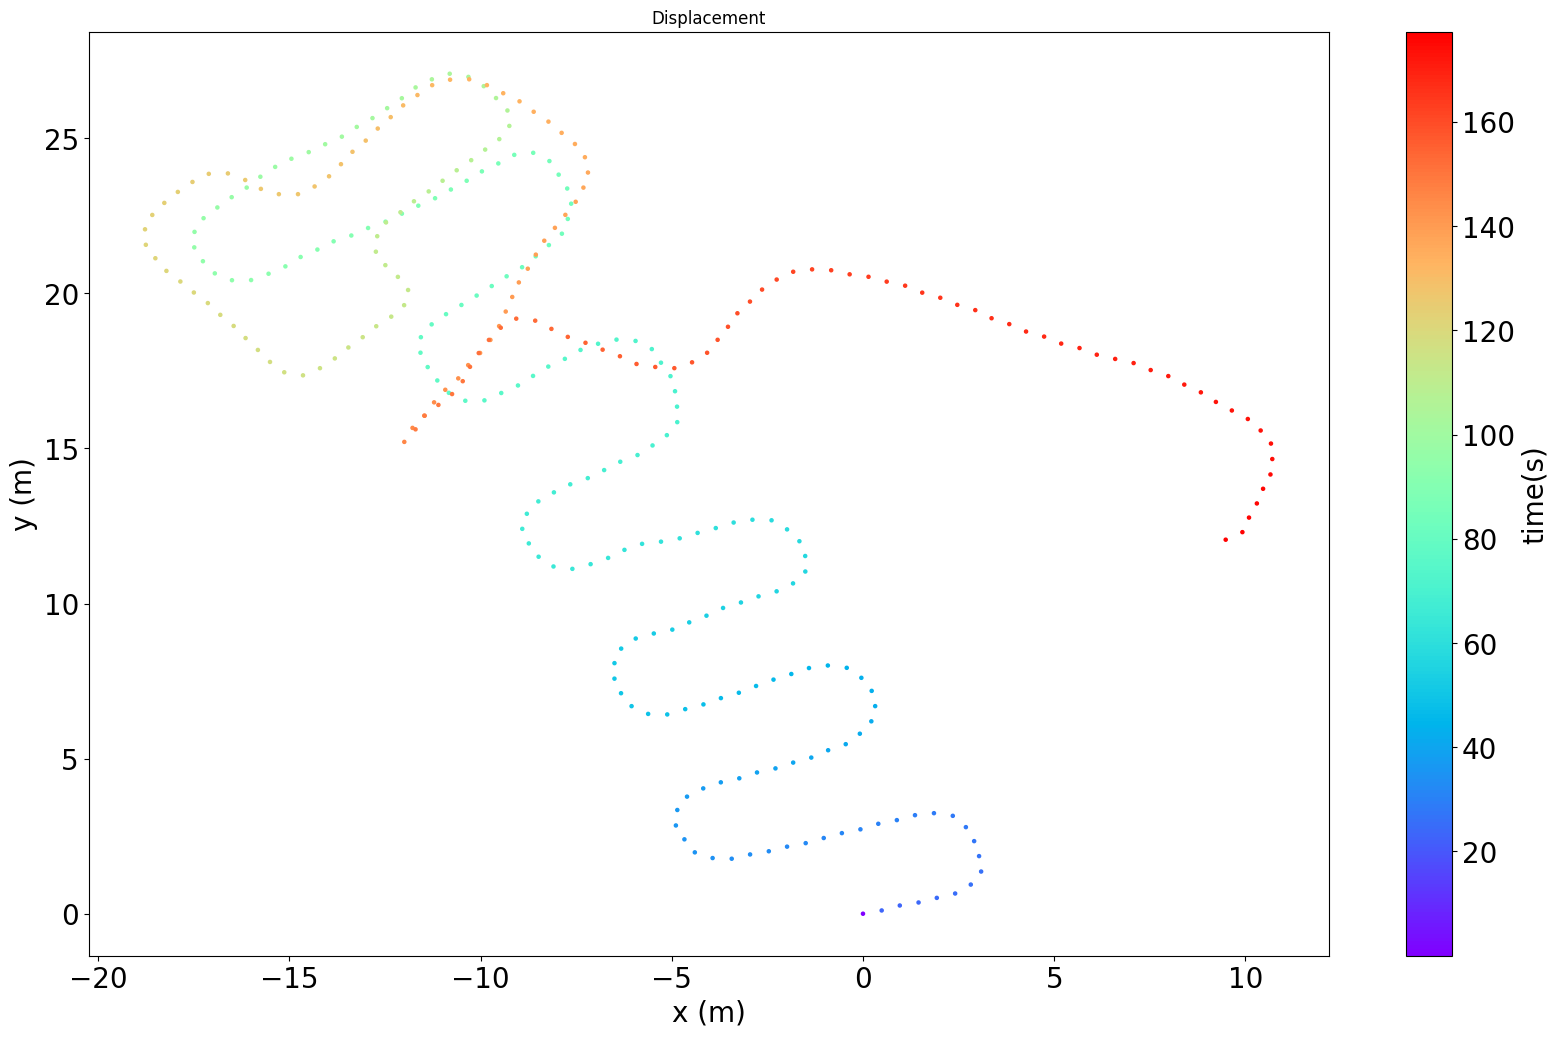

In [95]:
from sub import utils

importlib.reload(utils)

cumulative_displacement_df = (
    estimate.convert_to_peek_angle_and_compute_displacement_by_gyro(
        gyro,
        acc,
        peaks,
        0.5,
        {"x": 0, "y": 0},
        gt_ref["%time"][0],
    )
)


utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    cumulative_displacement_df,
)
scatter = plt.scatter(
    cumulative_displacement_df.x_displacement,
    cumulative_displacement_df.y_displacement,
    c=cumulative_displacement_df.ts,
    cmap="rainbow",
    s=5,
)
cbar = plt.colorbar(scatter)

# colorbarの文字サイズを大きく
cbar.ax.tick_params(labelsize=20)

# 単位を表示
cbar.set_label("time(s)", fontsize=20)

# xlabelの文字サイズを大きく
plt.tick_params(labelsize=20)
plt.xlabel("x (m)", fontsize=20)
plt.ylabel("y (m)", fontsize=20)
plt.title("Displacement")
plt.show()

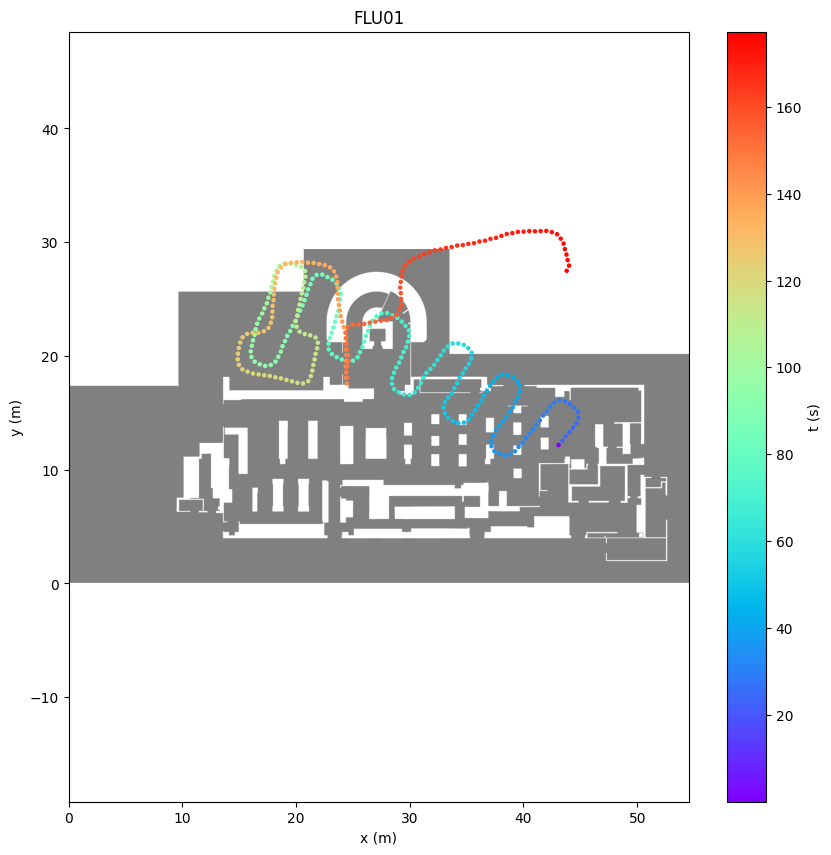

In [96]:
from sub import utils

importlib.reload(utils)

initial_direction = utils.extract_rotation(
    [gt_ref.q0[0], gt_ref.q1[0], gt_ref.q2[0], gt_ref.q3[0]],
)
diff = angle_in_step_timing["x"].values[0] - initial_direction

# 角度
rotate_by_first_half_angle = pd.DataFrame(
    {
        "ts": angle_df["ts"],
        "x": angle_df["x"] - diff,
    },
)

rotate_by_first_half_angle_displacement = (
    estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
        rotate_by_first_half_angle,
        acc,
        0.5,
        {"x": gt_ref.x[0], "y": gt_ref.y[0]},
        gt_ref["%time"][0],
    )
)

utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    rotate_by_first_half_angle_displacement,
)

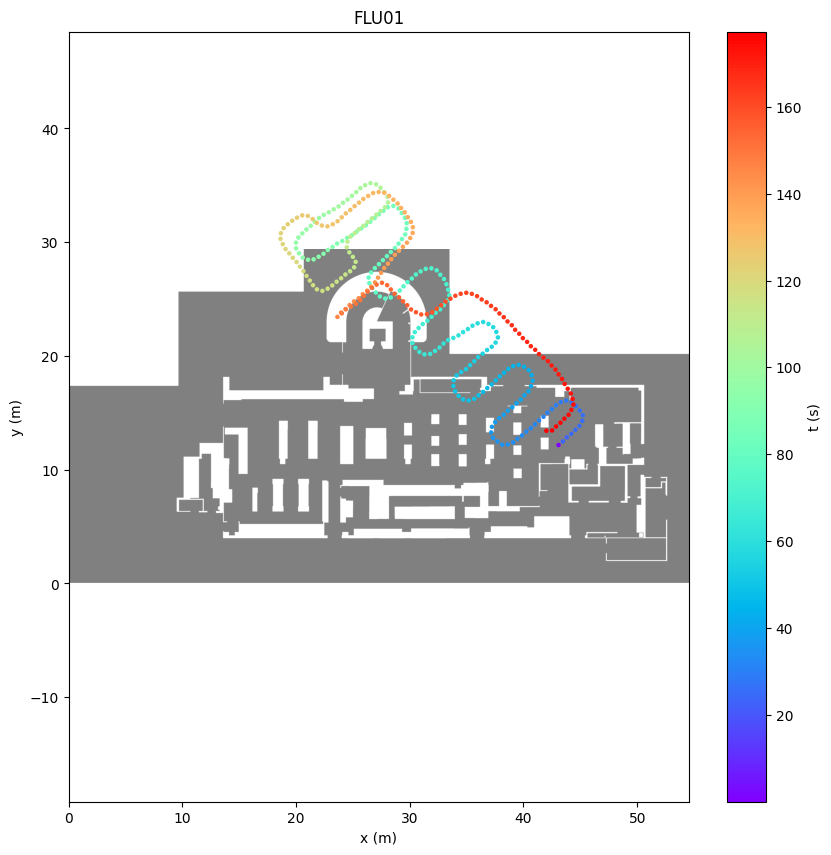

In [97]:
from sub import drift, utils

importlib.reload(drift)
importlib.reload(utils)

first_time_remove_drift_angle, first_time_remove_drift_angle_displacement = (
    drift.process_angle_data_with_drift_correction(
        rotate_by_first_half_angle,
        acc,
        gt_ref,
    )
)
# マップの描画
utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    first_time_remove_drift_angle_displacement,
    display_map=True,
)

angle                               2.43
horizontal_and_vertical_count    9157.00
exist_count                        87.00
Name: 3, dtype: float64


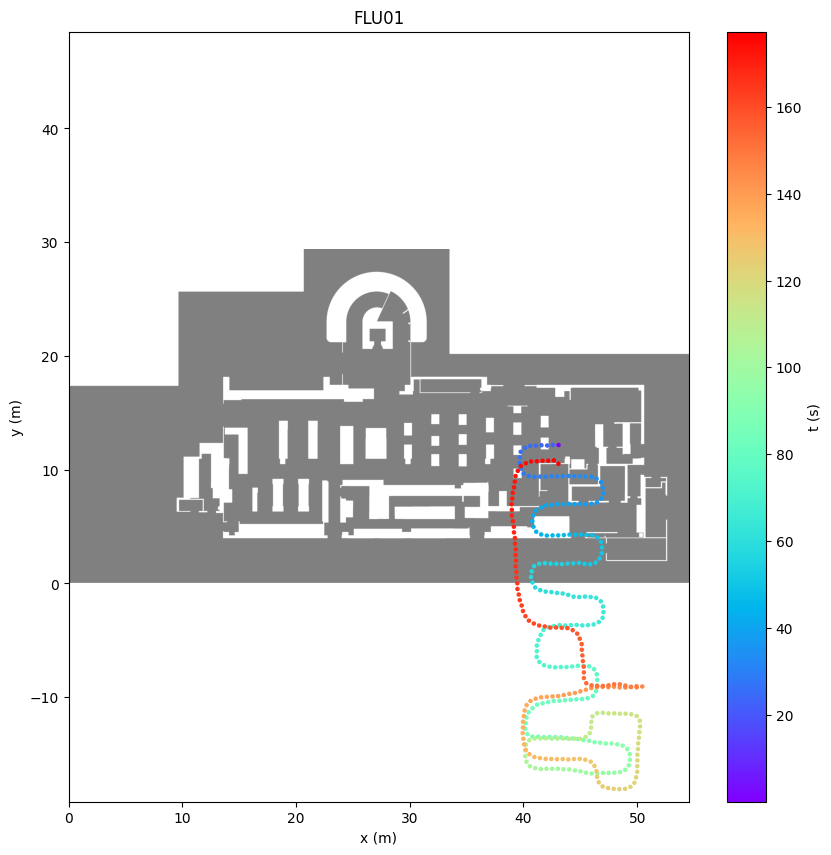

In [98]:
# refactored code

from sub import pdr_direction, utils

importlib.reload(pdr_direction)
importlib.reload(utils)

straight_angle, straight_angle_displacement = (
    pdr_direction.process_find_best_alignment_angle(
        acc,
        first_time_remove_drift_angle,
        gt_ref,
        edit_map_dict,
        floor_name,
        dx,
        dy,
    )
)

colors = straight_angle_displacement["is_vertical_or_horizontal"].map(
    {True: "r", False: "b", np.nan: "g"},
)
utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    straight_angle_displacement,
    display_map=True,
)

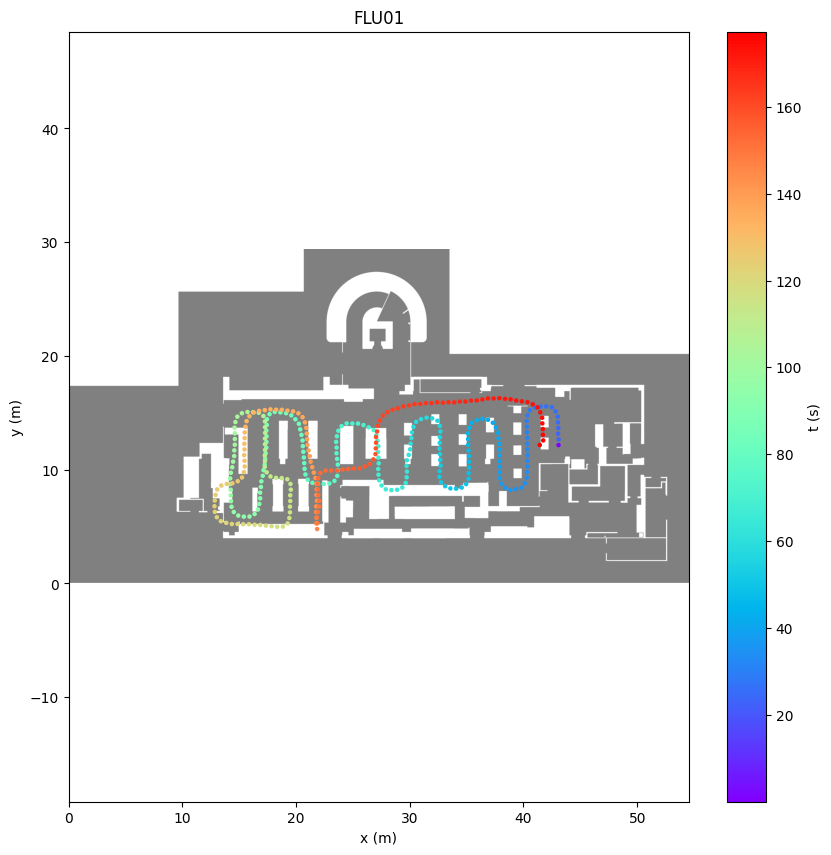

In [99]:
from sub import utils

importlib.reload(utils)

# 歩行ステップ時の角度に絞る
first_time_remove_drift_angle_matched_data = estimate.match_data(
    first_time_remove_drift_angle,
    angle_in_step_timing["ts"],
)
angle_by_vertical_horizontal = estimate.find_best_alignment_angle(
    first_time_remove_drift_angle_matched_data,
    gt_ref,
    edit_map_dict,
    floor_name,
    dx,
    dy,
)
straight_angle = pd.DataFrame(
    {
        "ts": first_time_remove_drift_angle.ts,
        "x": first_time_remove_drift_angle.x + angle_by_vertical_horizontal,
    },
)

straight_angle_displacement = (
    estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
        straight_angle,
        acc,
        0.5,
        {"x": gt_ref.x[0], "y": gt_ref.y[0]},
        gt_ref["%time"][0],
    )
)
utils.plot_displacement_map(
    map_dict,
    floor_name,
    dx,
    dy,
    straight_angle_displacement,
)

水平成分と垂直成分の色を変更するコード


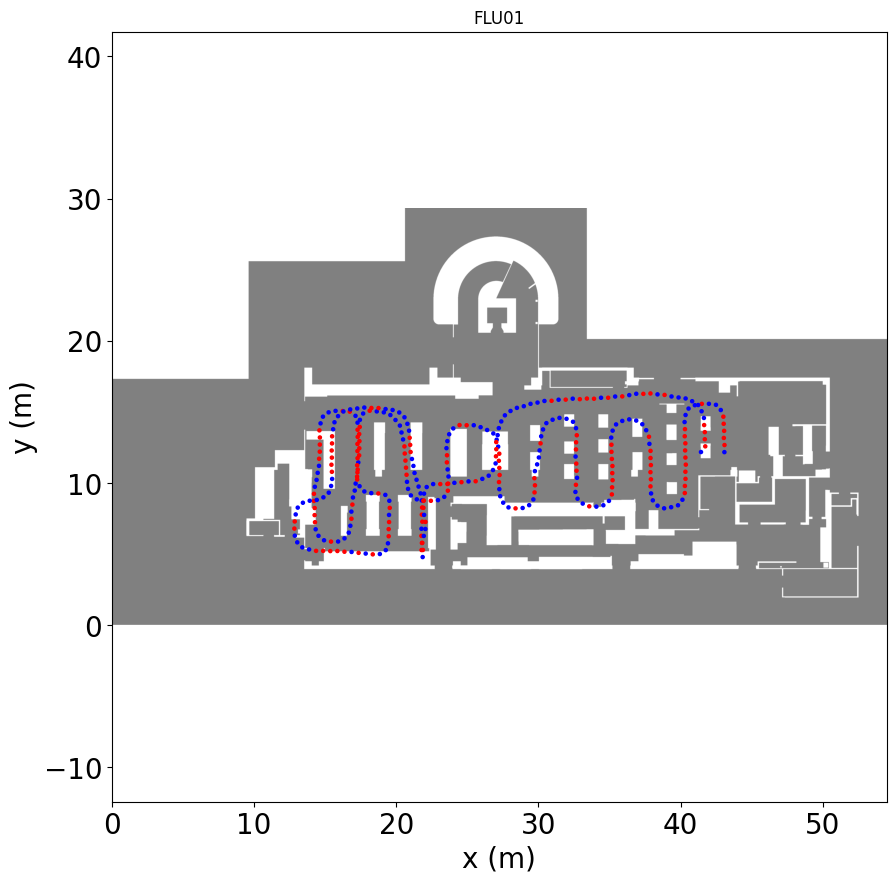

In [100]:
estimate.plot_map(map_dict, floor_name, dx, dy)
colors = straight_angle_displacement["is_vertical_or_horizontal"].map(
    {True: "r", False: "b", np.nan: "b"},
)
plt.scatter(
    straight_angle_displacement.x_displacement,
    straight_angle_displacement.y_displacement,
    c=colors,
    s=5,
)


plt.tick_params(labelsize=20)
plt.xlabel("x (m)", fontsize=20)
plt.ylabel("y (m)", fontsize=20)

plt.show()

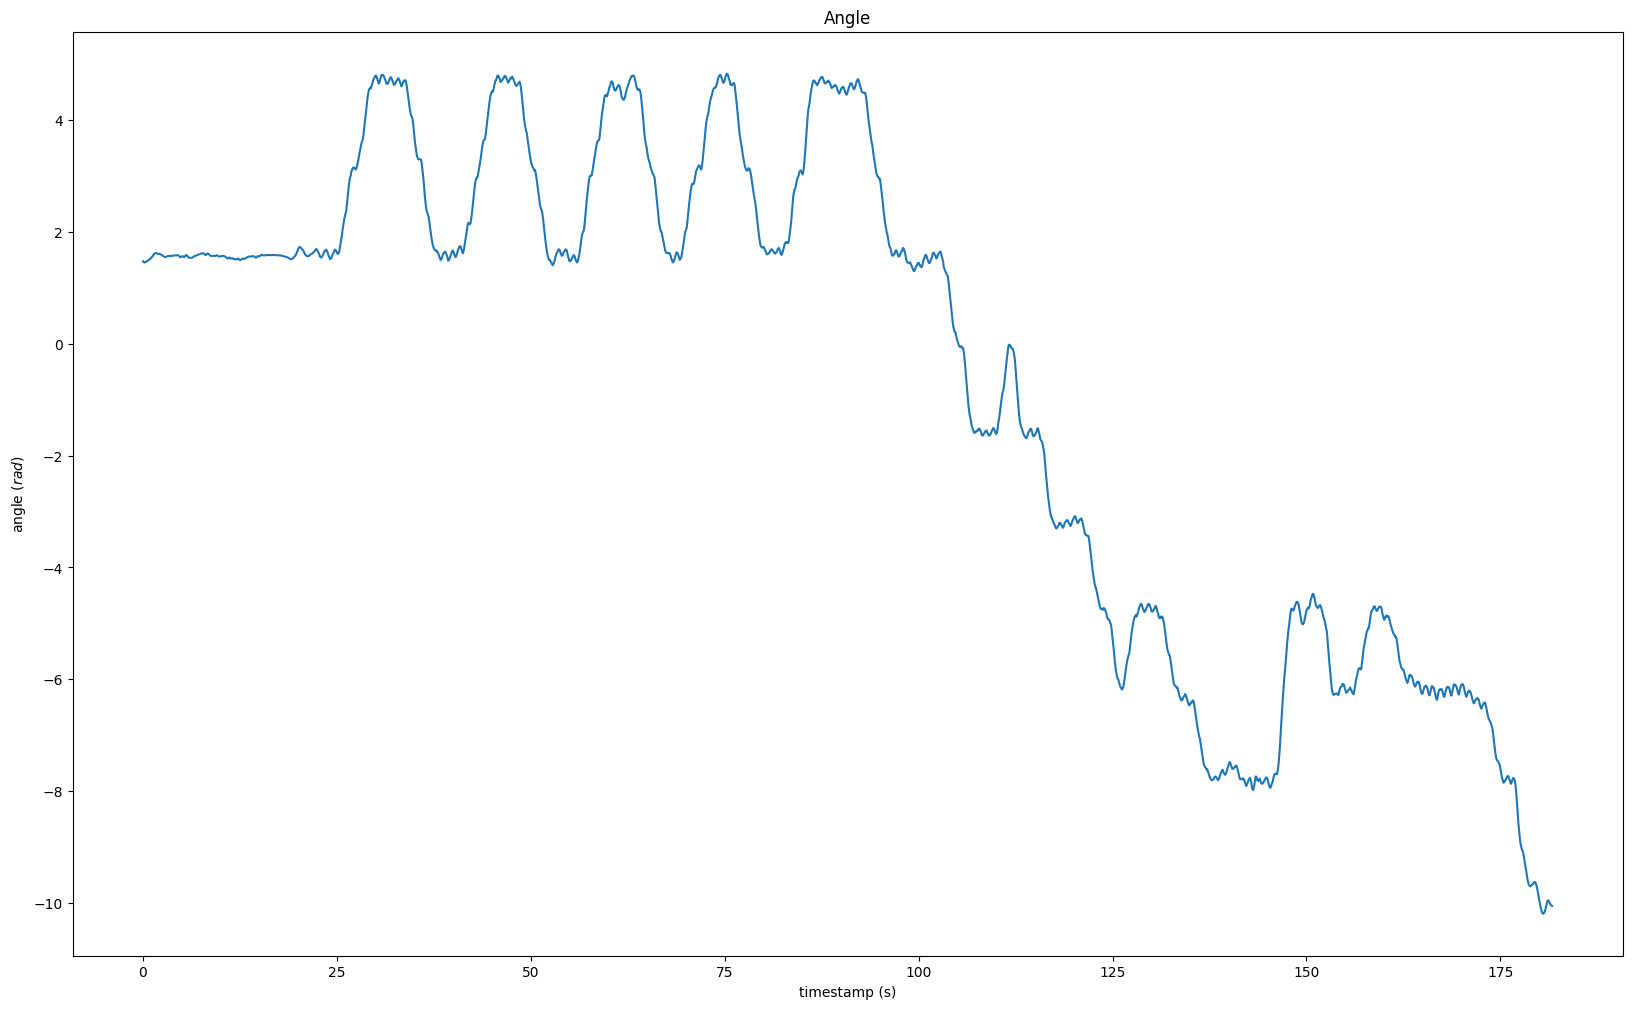

In [101]:
plt.plot(straight_angle.ts, straight_angle["x"])
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()

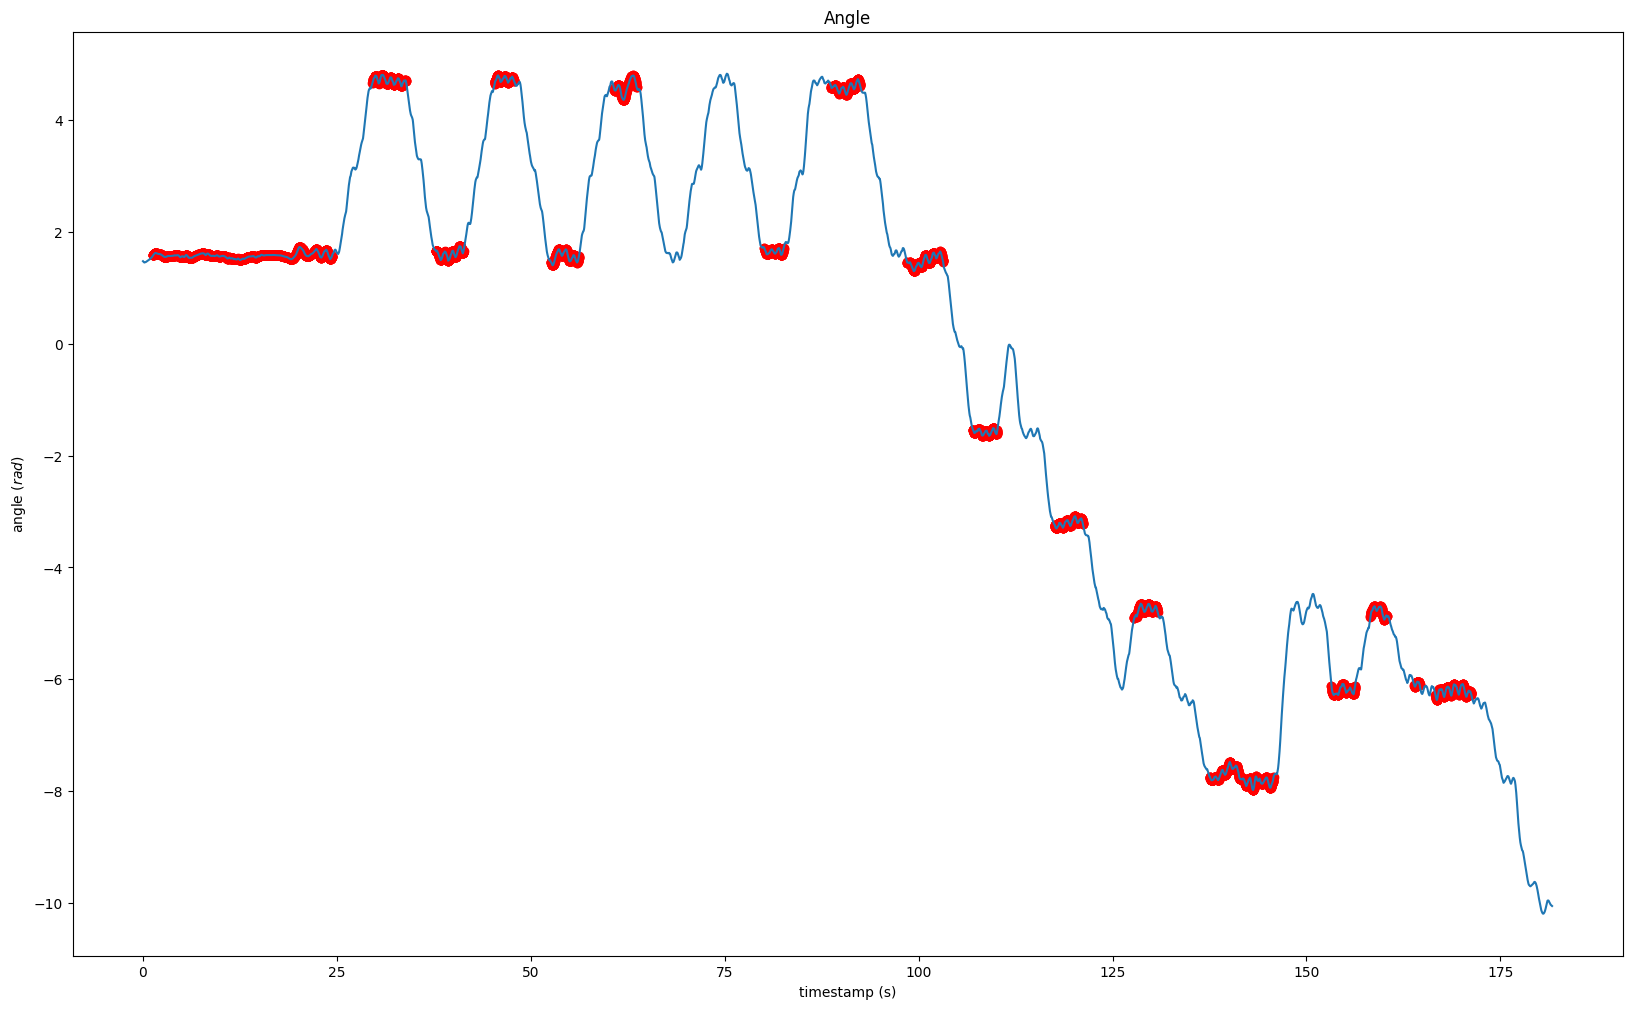

In [102]:
# 安定歩行区間を設けて，その区間に入っている場合角度を補正する
# 安定歩行区間とは，角度が一定範囲内に数秒間収まっている区間のこと
# 角度範囲は+-20度とする，数秒間は5秒とする


def extract_stable_angle(
    angle_df: pd.DataFrame,
    stable_angle_range: float,
    stable_time: float,
) -> pd.DataFrame:
    stable_angle_df = pd.DataFrame()
    stable_angle_df["ts"] = angle_df["ts"]
    stable_angle_df["x"] = angle_df["x"]
    stable_angle_df["stable_flag"] = False

    start_row = stable_angle_df.iloc[0]
    elasted_time = 0
    stable_flag = False
    for index, row in stable_angle_df.iterrows():
        if (
            start_row["x"] - stable_angle_range
            <= row["x"]
            <= start_row["x"] + stable_angle_range
        ):
            elasted_time = row["ts"] - start_row["ts"]
            if elasted_time >= stable_time:
                stable_flag = True
        else:
            if stable_flag == True:
                stable_flag = False

                # stable_row.nameからrow.nameまでの平均を求める
                average = stable_angle_df.loc[start_row.name : row.name, "x"].mean()
                last_row_x = stable_angle_df.loc[row.name, "x"]

                # ステップ1: データの取得
                subset_data = stable_angle_df.loc[start_row.name : row.name, "x"]
                # ステップ2: 条件によるフィルタリング
                if last_row_x - average > 0:
                    filtered_values = subset_data[subset_data < average]
                else:
                    filtered_values = subset_data[subset_data > average]

                last_index = filtered_values.tail(1).index[0]

                if start_row.name - average > 0:
                    filtered_values = subset_data[subset_data < average]
                else:
                    filtered_values = subset_data[subset_data > average]

                first_index = filtered_values.head(1).index[0]

                # stable_angle_df.loc[start_row.name:row.name,'stable_flag']=True
                # stable_angle_df.loc[start_row.name:last_index,'stable_flag']=True
                stable_angle_df.loc[first_index:last_index, "stable_flag"] = True

            start_row = row

    return stable_angle_df


def correct_angle(stable_angle_df: pd.DataFrame, angle_column: str) -> pd.DataFrame:
    corrected_angle_df = stable_angle_df.copy()

    # 安定歩行区間での角度を修正する
    for index, row in stable_angle_df.iterrows():
        if row["stable_flag"]:
            angle = row[angle_column]
            # 最も近い安定歩行の角度を計算
            # 安定歩行の角度リスト（斜め方向も考慮）
            stable_angles = [
                0,
                1.5708,
                3.14159,
                4.71239,
                6.28319,
                7.85399,
                9.42478,
                10.9956,
                12.5664,
                14.1372,
                15.708,
                17.2788,
                18.8496,
                -1.5708,
                -3.14159,
                -4.71239,
                -6.28319,
                -7.85399,
                -9.42478,
                -10.9956,
                -12.5664,
                -14.1372,
                -15.708,
                -17.2788,
                -18.8496,
                0.7854,
                2.35619,
                -0.7854,
                -2.35619,
            ]
            closest_angle = min(stable_angles, key=lambda x: abs(x - angle))
            # 修正する
            corrected_angle_df.at[index, angle_column] = closest_angle

    return corrected_angle_df


stable_angle_df = extract_stable_angle(straight_angle, 0.35, 3)


# plotする stable_flagがtrueのものは赤色で表示
plt.plot(stable_angle_df.ts, stable_angle_df["x"])
plt.scatter(
    stable_angle_df["ts"][stable_angle_df["stable_flag"]],
    stable_angle_df["x"][stable_angle_df["stable_flag"]],
    c="r",
)
plt.xlabel("timestamp (s)")
plt.ylabel("angle ($rad$)")
plt.title("Angle")
plt.show()

In [103]:
# import pandas as pd
# import matplotlib.pyplot as plt


# def refine_stable_regions_stricter(stable_angle_df, method='median', threshold_multiplier=0.5):
#     refined_df = stable_angle_df.copy()

#     # 安定歩行区間のインデックスを取得
#     stable_regions = []
#     start_idx = None
#     for idx, row in stable_angle_df.iterrows():
#         if row['stable_flag']:
#             if start_idx is None:
#                 start_idx = idx
#         else:
#             if start_idx is not None:
#                 stable_regions.append((start_idx, idx))
#                 start_idx = None

#     for start, end in stable_regions:
#         subset = stable_angle_df.loc[start:end, 'x']

#         # 指定された方法で中心値を計算
#         if method == 'mean':
#             center_value = subset.mean()
#         elif method == 'median':
#             center_value = subset.median()
#         elif method == 'mode':
#             center_value = subset.mode()[0]

#         # 中心値から大きく外れるデータを安定歩行区間から除外
#         threshold = threshold_multiplier * 0.35  # これは調整が必要かもしれません
#         outliers = (subset < center_value - threshold) | (subset > center_value + threshold)
#         refined_df.loc[outliers[outliers].index, 'stable_flag'] = False

#     return refined_df

# def is_stable_window(data, stable_angle_range):
#     # ウィンドウ内の最大値と最小値の差が安定範囲内に収まっているか判定
#     return (data.max() - data.min()) <= 2 * stable_angle_range

# def extract_stable_angle_with_sliding_window(angle_df: pd.DataFrame, stable_angle_range: float, stable_time: float) -> pd.DataFrame:
#     stable_angle_df = angle_df.copy()
#     stable_angle_df['stable_flag'] = False

#     window_size = int(stable_time / (angle_df['ts'].iloc[1] - angle_df['ts'].iloc[0]))  # ウィンドウサイズの計算（データポイント数）

#     for i in range(len(angle_df) - window_size + 1):
#         window_data = angle_df.iloc[i:i+window_size]['x']
#         if is_stable_window(window_data, stable_angle_range):
#             stable_angle_df.loc[angle_df.index[i:i+window_size], 'stable_flag'] = True

#     return stable_angle_df


# # スライドウィンドウを使用した関数を適用
# stable_angle_df = extract_stable_angle_with_sliding_window(straight_angle, 0.1, 3)
# # プロット
# plt.plot(stable_angle_df.ts, stable_angle_df['x'])
# plt.scatter(stable_angle_df['ts'][stable_angle_df['stable_flag']], stable_angle_df['x'][stable_angle_df['stable_flag']], c='r')
# plt.xlabel("timestamp (s)",fontsize=20)
# plt.ylabel("angle ($rad$)",fontsize=20)
# plt.show()

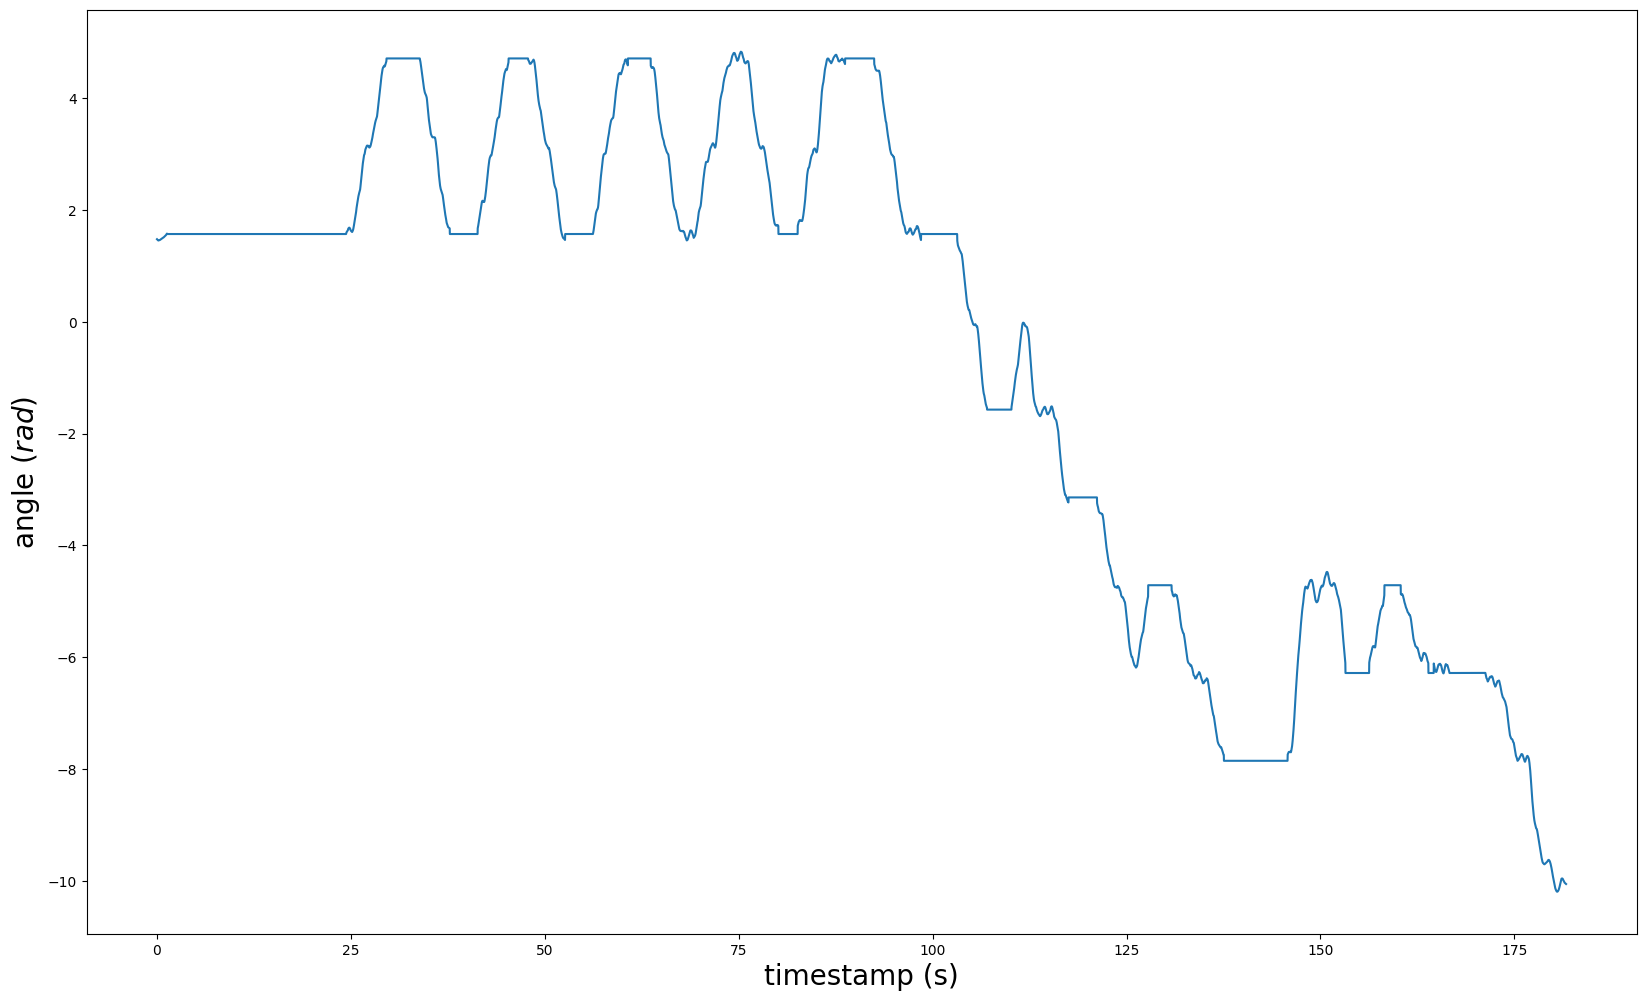

In [104]:
correct_angle_df = correct_angle(stable_angle_df, "x")

plt.plot(correct_angle_df.ts, correct_angle_df["x"])
plt.xlabel("timestamp (s)", fontsize=20)
plt.ylabel("angle ($rad$)", fontsize=20)
plt.show()

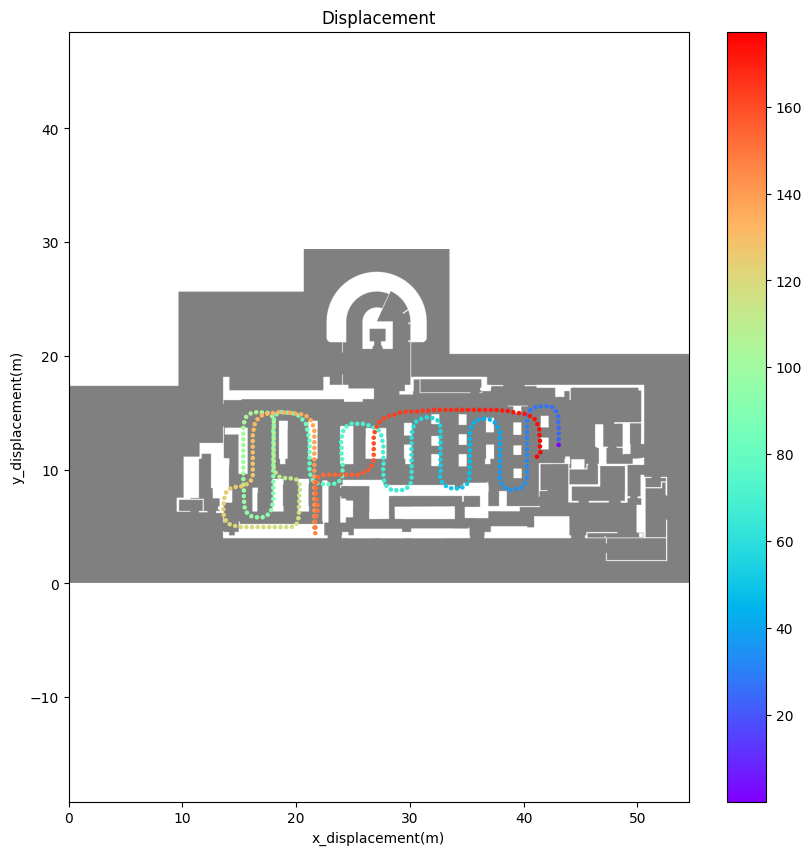

In [105]:
correct_angle_df_displacement = (
    estimate.convert_to_peek_angle_and_compute_displacement_by_angle(
        correct_angle_df,
        acc,
        0.5,
        {"x": gt_ref.x[0], "y": gt_ref.y[0]},
        gt_ref["%time"][0],
    )
)

estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        correct_angle_df_displacement.x_displacement,
        correct_angle_df_displacement.y_displacement,
        c=correct_angle_df_displacement.ts,
        cmap="rainbow",
        s=5,
    ),
)

plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

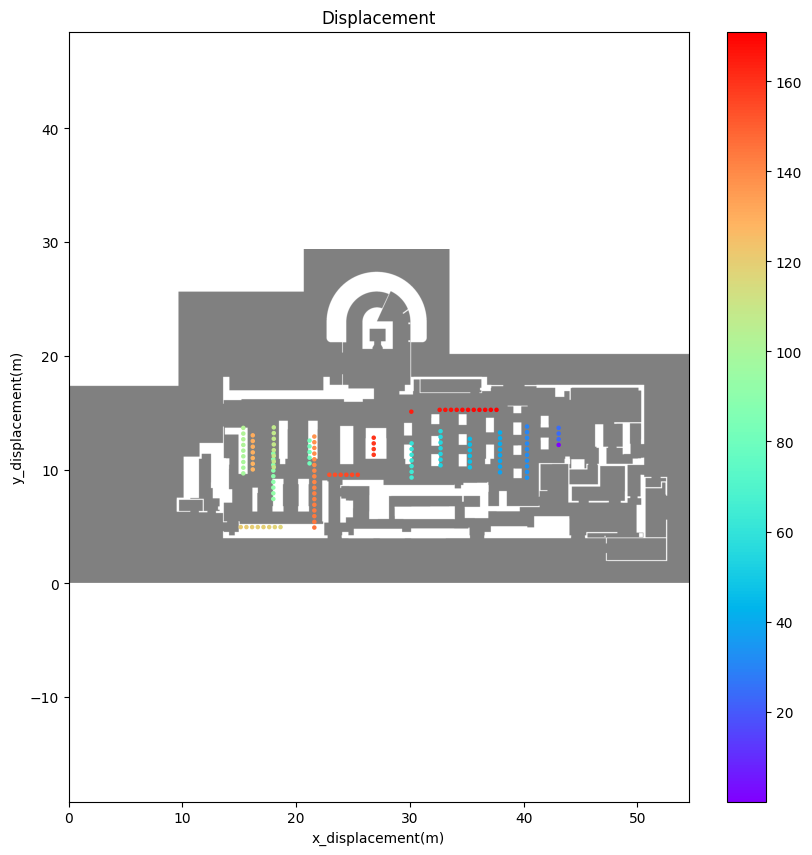

In [106]:
def match_data(angle_df: pd.DataFrame, peek_t: pd.Series):
    matched_df = pd.DataFrame()
    for t in peek_t:
        matched_row = angle_df[np.isclose(angle_df["ts"], t, atol=0.005)]
        matched_df = pd.concat([matched_df, matched_row])
    return matched_df


def calculate_cumulative_displacement(
    ts: pd.Series,
    angle_data: pd.Series,
    step_length: float,
    initial_point: dict[str, float],
    initial_timestamp: float = 0.0,
):
    x_displacement = step_length * np.cos(angle_data["x"])
    y_displacement = step_length * np.sin(angle_data["x"])

    init_data_frame = pd.DataFrame(
        {
            "ts": [initial_timestamp],
            "x_displacement": initial_point["x"],
            "y_displacement": initial_point["y"],
            "stable_flag": angle_data["stable_flag"].values[0],
        },
    )

    return pd.concat(
        [
            init_data_frame,
            pd.DataFrame(
                {
                    "ts": ts,
                    "x_displacement": x_displacement.cumsum() + initial_point["x"],
                    "y_displacement": y_displacement.cumsum() + initial_point["y"],
                    "stable_flag": angle_data["stable_flag"],
                },
            ),
        ],
    )


def convert_to_peek_angle_and_compute_displacement_by_angle(
    angle: pd.DataFrame,
    acc: pd.DataFrame,
    peaks: np.ndarray,
    step_length: float,
    initial_point: dict[str, float],
    initial_timestamp: float = 0.0,
):
    # 歩行タイミング時の角度をmatch_data関数を用いて取得
    angle_in_step_timing = match_data(angle, acc.ts[peaks])

    # 累積変位を計算
    cumulative_displacement_df = calculate_cumulative_displacement(
        angle_in_step_timing.ts,
        angle_in_step_timing,
        step_length,
        initial_point,
        initial_timestamp,
    )

    return cumulative_displacement_df


correct_angle_df_displacement = convert_to_peek_angle_and_compute_displacement_by_angle(
    correct_angle_df,
    acc,
    peaks,
    0.5,
    {"x": gt_ref.x[0], "y": gt_ref.y[0]},
    gt_ref["%time"][0],
)

# stable_flagがtrueのもののみを描く
estimate.plot_map(map_dict, floor_name, dx, dy)
plt.colorbar(
    plt.scatter(
        correct_angle_df_displacement.x_displacement[
            correct_angle_df_displacement["stable_flag"]
        ],
        correct_angle_df_displacement.y_displacement[
            correct_angle_df_displacement["stable_flag"]
        ],
        c=correct_angle_df_displacement.ts[
            correct_angle_df_displacement["stable_flag"]
        ],
        cmap="rainbow",
        s=5,
    ),
)
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

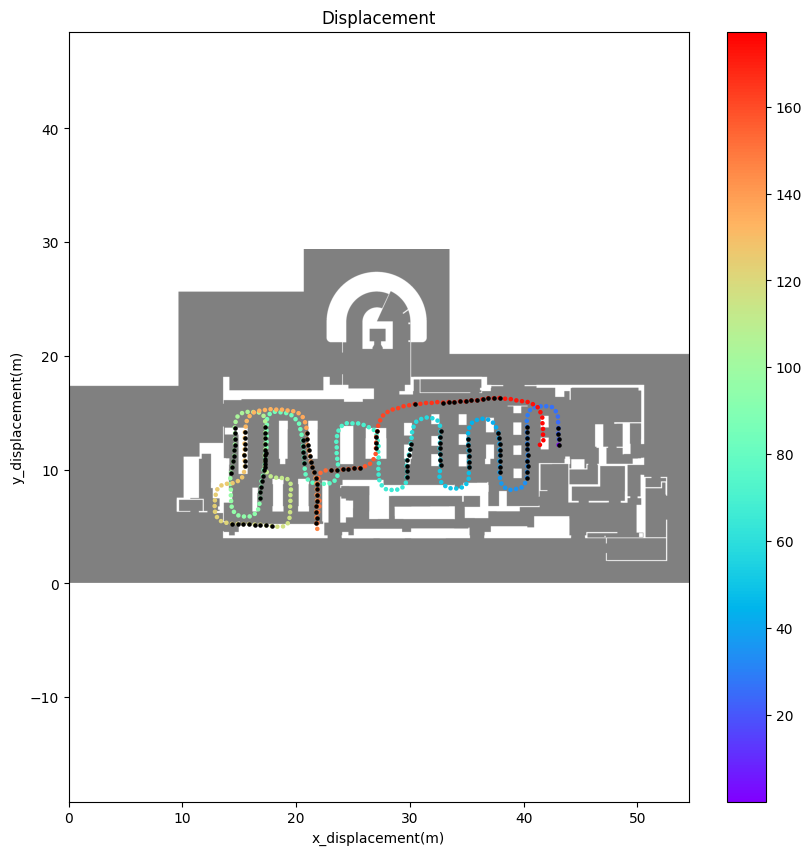

In [107]:
# straight_angle_displacementにcorrect_angle_df_displacementのstable_flagを追加
straight_angle_displacement["stable_flag"] = correct_angle_df_displacement[
    "stable_flag"
]

estimate.plot_map(map_dict, floor_name, dx, dy)
# 普通に表示
plt.colorbar(
    plt.scatter(
        straight_angle_displacement.x_displacement,
        straight_angle_displacement.y_displacement,
        c=straight_angle_displacement.ts,
        cmap="rainbow",
        s=5,
    ),
)
# stable_flagがtrueのものは黒色で表示
plt.scatter(
    straight_angle_displacement.x_displacement[
        straight_angle_displacement["stable_flag"]
    ],
    straight_angle_displacement.y_displacement[
        straight_angle_displacement["stable_flag"]
    ],
    c="k",
    s=5,
)
plt.xlabel("x_displacement(m)")
plt.ylabel("y_displacement(m)")
plt.title("Displacement")
plt.show()

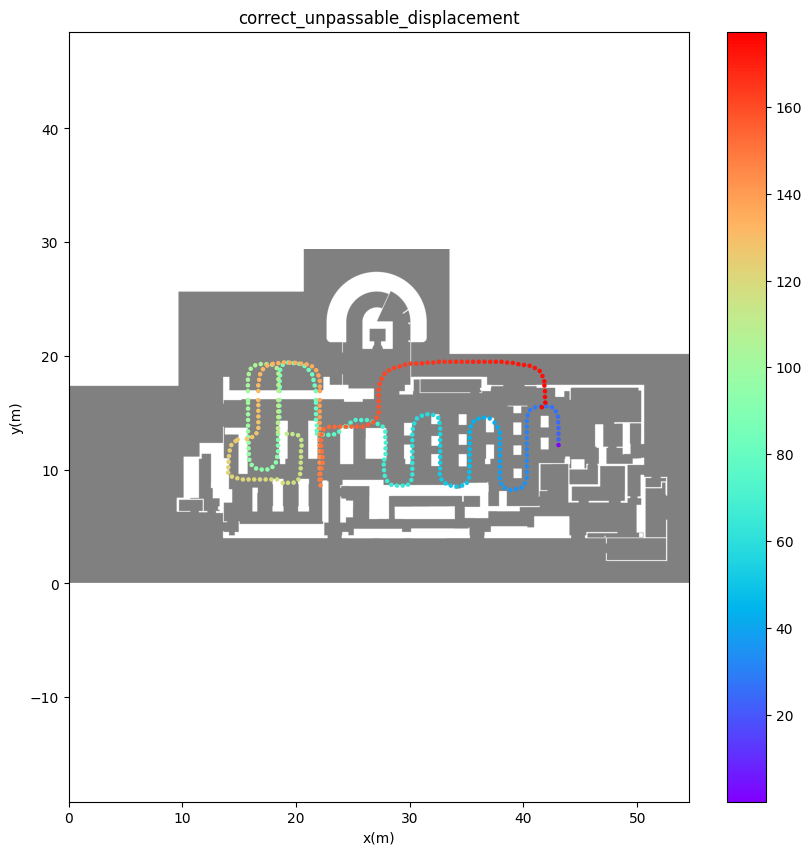

In [108]:
# correct_unpassable_displacement = estimate.correct_unpassable_points(straight_angle_displacement, map_dict, floor_name, dx, dy)
correct_unpassable_displacement = estimate.correct_unpassable_points(
    correct_angle_df_displacement,
    map_dict,
    floor_name,
    dx,
    dy,
)


estimate.plot_map(
    map_dict,
    floor_name,
    dx,
    dy,
)

plt.colorbar(
    plt.scatter(
        correct_unpassable_displacement["x_displacement"],
        correct_unpassable_displacement["y_displacement"],
        c=correct_unpassable_displacement["ts"],
        cmap="rainbow",
        s=5,
    ),
)
plt.xlabel("x(m)")
plt.ylabel("y(m)")
plt.title("correct_unpassable_displacement")
plt.show()


output_df = pd.DataFrame(
    {
        "timestamp": correct_unpassable_displacement["ts"],
        "x": correct_unpassable_displacement["x_displacement"],
        "y": correct_unpassable_displacement["y_displacement"],
        "floor": floor_name,
    },
)

output_df.to_csv("8_1_pdr_est.csv", index=False, header=False)